
# Phân tích doanh thu và hiệu suất bán hàng
- Tổng doanh thu theo ngày, tuần, tháng, xác định ngày nào trong tuần bán chạy nhất của tất cả cửa hàng và của từng cửa hàng.
- So sánh hiệu suất bán hàng của từng cửa hàng
- Phân tích tác động của giảm giá (số lượng bán ra và doanh thu trước và sau giảm giá)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
import os
sys.path.append('../../../scripts/')
import data_cleaning

# 1. Import data
Nhập dữ liệu đã qua xử lý, data đã clean 20240722

In [2]:
df_menuitem = pd.read_csv("../../../data/processed/20240802/2.menuitem_20240802.csv")
df_menuitem.head()

MD5KEY_MENUITEM                  MD5KEY_ORDERSALE  \
0  001E0224E4EDA63D6FED96D59E0C1E76  072D3B76BE58E4553A373AF3206D2CA5   
1  003E4E20196B2F5BDD33CE06D2943EF4  14811D4F3458058007B0B6908C2DA393   
2  012A55E5551C95A559A7B074AE85117E  22FA6C39B7A15ABB6EB568E66A6B30E1   
3  01B07F1C6DC6945796571FC78735DA16  915B69612845BBD974C39AC105F5CA8C   
4  02DE19974DE5304BF243A1C2EC639495  CD6386C802450EDCF13A3D112D1F86EC   

  CategoryDescription  DepartmentDescription           Description  \
0            Footlong           Footlong Sub  Chickn Strips FtLong   
1            Fountain  Fountain Drink 21 oz.   21oz Fountain Drink   
2              6 Inch             6 Inch Sub         B.M.T. 6 inch   
3              6 Inch             6 Inch Sub  Veggie Delite 6 inch   
4              Add On     Add On 6in Portion        Avocado Add6in   

   StoreNumber  TaxAmount  AdjustedPrice  DiscountAmount  Price  Quantity  \
0        46673     0.6975           7.75            0.00   7.75         1   
1        46673     0.1530           1.70            0.00   1.70         1   
2        12631     0.3230           3.64            0.61   4.25         1   
3        12631     0.3328           3.75            0.00   3.75         1   
4        12631     0.0443           0.50            0.00   0.50         1   

         PLU   Id        date  SalesAmount day_of_week  DiscountPercentage  
0  111000041  326  2015-03-05         7.75    Thursday            0.000000  
1  212000126  280  2015-03-05         1.70    Thursday            0.000000  
2  121000008    8  2015-03-05         3.64    Thursday           14.352941  
3  121000001   91  2015-03-05         3.75    Thursday            0.000000  
4  175000062  564  2015-03-05         0.50    Thursday            0.000000

In [3]:
df_menuitem['date'] = pd.to_datetime(df_menuitem['date'], format='%Y-%m-%d')

In [4]:
df_menuitem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91420 entries, 0 to 91419
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   MD5KEY_MENUITEM        91420 non-null  object        
 1   MD5KEY_ORDERSALE       91420 non-null  object        
 2   CategoryDescription    91420 non-null  object        
 3   DepartmentDescription  91420 non-null  object        
 4   Description            91420 non-null  object        
 5   StoreNumber            91420 non-null  int64         
 6   TaxAmount              91420 non-null  float64       
 7   AdjustedPrice          91420 non-null  float64       
 8   DiscountAmount         91420 non-null  float64       
 9   Price                  91420 non-null  float64       
 10  Quantity               91420 non-null  int64         
 11  PLU                    91420 non-null  int64         
 12  Id                     91420 non-null  int64         
 13  d

In [5]:
df_ordersale = pd.read_csv("../../../data/processed/20240722/1.pos_ordersale_20240722.csv")
df_ordersale.head()

MD5KEY_ORDERSALE  ChangeReceived  OrderNumber  TaxAmount  \
0  00BCB738A1F814DB960C25012E9913DF            0.00           67       0.56   
1  03438C257BC2DD0037F35EC8BFC0C8E2            3.46           39       0.54   
2  04AEF56CF3130AC1EFAD41C470F5245D            0.00           81       0.69   
3  04BBFAD4E73C30EE2EC3B4E52509637C            0.00          159       1.16   
4  061AE382DC127057E8ADBBF869CFB361            0.00           51       0.00   

   MealLocation  TransactionId  StoreNumber        date  
0             0             67        46673  2015-03-05  
1             0             39        12631  2015-03-05  
2             0             79        46673  2015-03-05  
3             0            159        12631  2015-03-05  
4             0             51        12631  2015-03-05

In [6]:
df_ordersale['date'] = pd.to_datetime(df_ordersale['date'], format='%Y-%m-%d')

In [7]:
df_ordersale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43228 entries, 0 to 43227
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   MD5KEY_ORDERSALE  43228 non-null  object        
 1   ChangeReceived    43228 non-null  float64       
 2   OrderNumber       43228 non-null  int64         
 3   TaxAmount         43228 non-null  float64       
 4   MealLocation      43228 non-null  int64         
 5   TransactionId     43228 non-null  int64         
 6   StoreNumber       43228 non-null  int64         
 7   date              43228 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 2.6+ MB


# 2. Phân tích doanh thu ngày và ngày trong tuần
Phân tích doanh thu thao ngày, ngày trong tuần để hiểu rõ hơn về xu hướng doanh thu của tổng quan và của từng cửa hàng.

## 2.1 Doanh thu
Để phân tích doanh cần các trường trong file menuitem:
- SalesAmount
- date
- day_of_week

In [8]:
# Doanh thu tổng theo ngày
revenue_by_day = df_menuitem.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week = revenue_by_day.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()


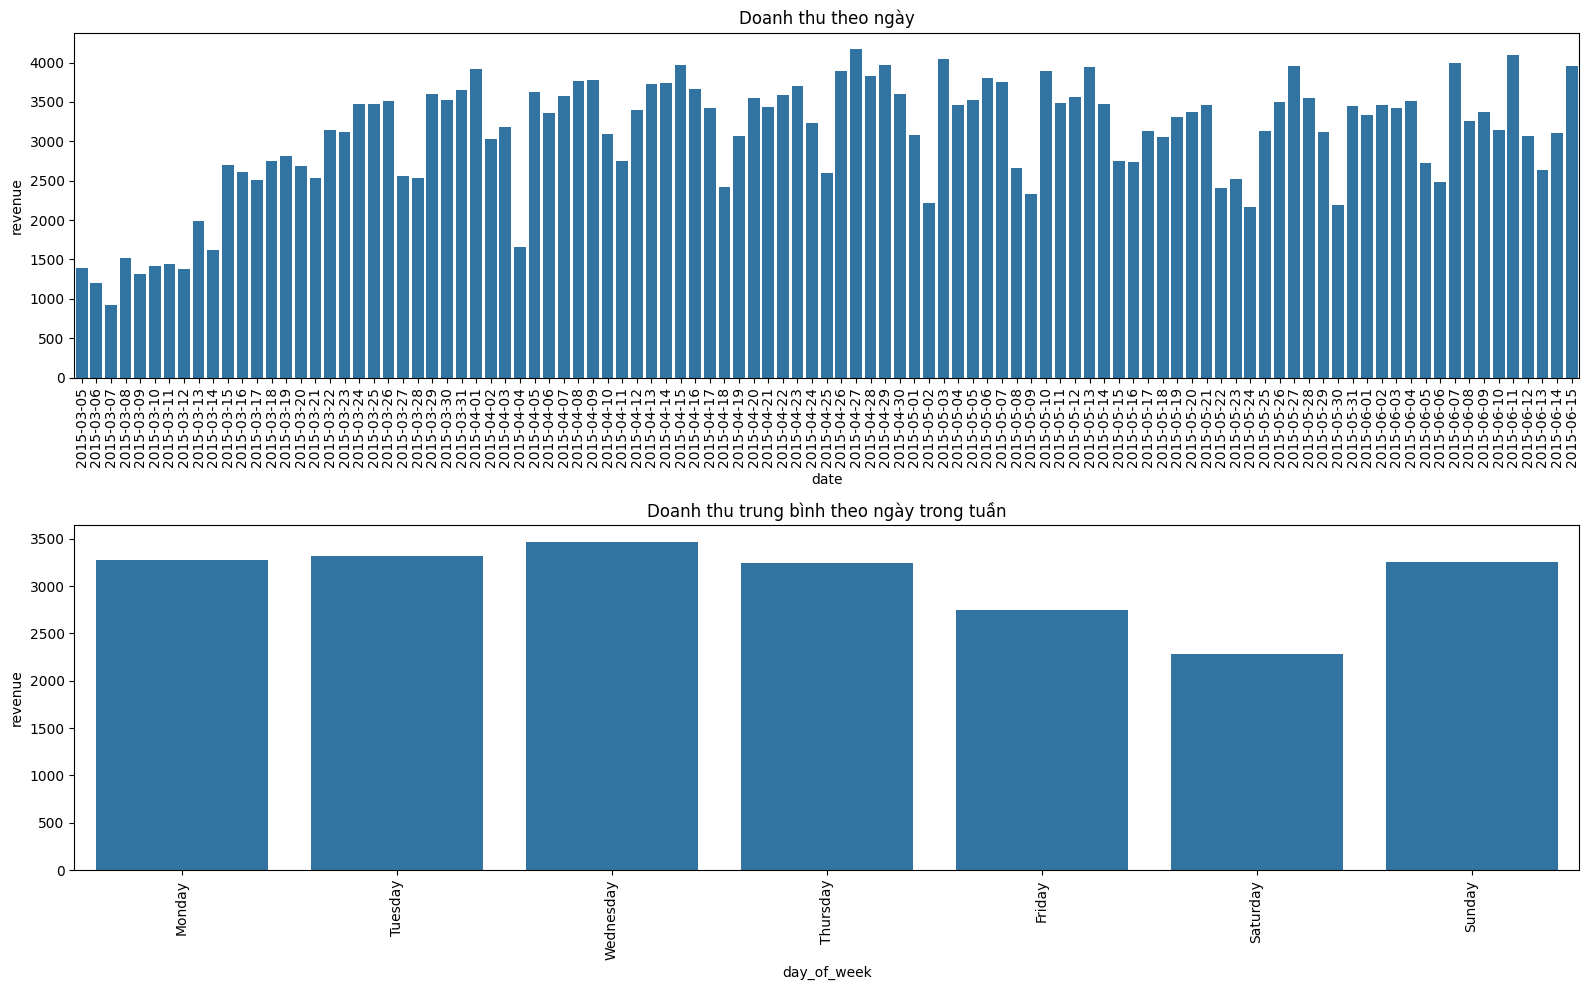

In [9]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình theo ngày trong tuần")

plt.tight_layout()
plt.show()

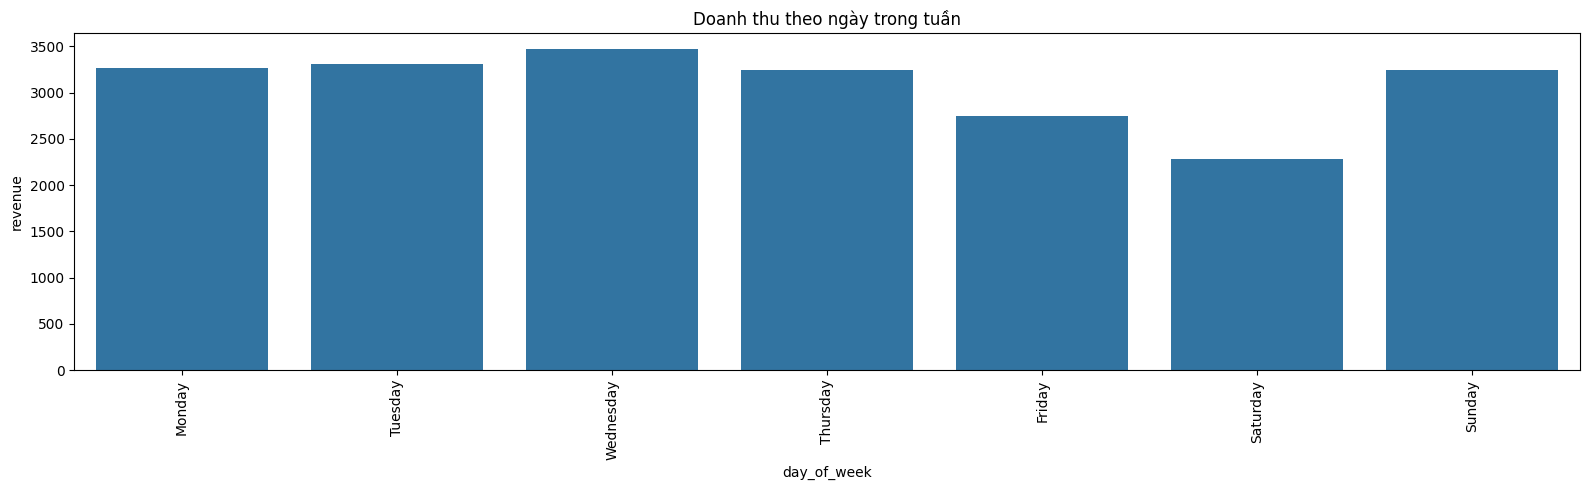

In [10]:
plt.figure(figsize=(16, 5))

sns.barplot(data=revenue_day_of_week,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

### Check các ngày doanh thu đột biến là thứ mấy

In [11]:
print(df_menuitem[df_menuitem['date'] == '2015-04-04'].loc[:, 'day_of_week'].unique())
print(df_menuitem[df_menuitem['date'] == '2015-05-02'].loc[:, 'day_of_week'].unique())
print(df_menuitem[df_menuitem['date'] == '2015-05-23'].loc[:, 'day_of_week'].unique())

['Saturday']
['Saturday']
['Saturday']


### 2.1.1 Tách outliers Quantity

#### 2.1.1.1 Cho món ăn

In [12]:
# Tính Q1_quantity (25th percentile) và Q3_Quantity (75th percentile)
Q1_quantity = df_menuitem['Quantity'].quantile(0.25)
Q3_quantity = df_menuitem['Quantity'].quantile(0.75)

# Tính IQR_quantity
IQR_quantity = Q3_quantity - Q1_quantity

# Xác định giới hạn dưới và trên
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Xác định giá trị ngoại lai
outliers_quantity = df_menuitem[(df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity)].copy()
non_outliers_quantity = df_menuitem[~((df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity))].copy()

In [13]:
print("Số hàng menuitem:", df_menuitem.shape[0])
print("Tổng hàng outliers và non_outliers:", outliers_quantity.shape[0] + non_outliers_quantity.shape[0])
print()
print("% outliers:", outliers_quantity.shape[0] / df_menuitem.shape[0] * 100)
print("Số hàng outliers:", outliers_quantity.shape[0])
print("Số hàng non_outliers:", non_outliers_quantity.shape[0])
print()
print('Doanh thu', df_menuitem['SalesAmount'].sum())
print('Doanh thu outliers:', outliers_quantity['SalesAmount'].sum())
print('Doanh thu non_outliers:', non_outliers_quantity['SalesAmount'].sum())
print('Check doanh thu outlier + non_outliers:', outliers_quantity['SalesAmount'].sum() + non_outliers_quantity['SalesAmount'].sum())
print()
print('% doanh thu outliers:', outliers_quantity['SalesAmount'].sum() / df_menuitem['SalesAmount'].sum() * 100)

Số hàng menuitem: 91420
Tổng hàng outliers và non_outliers: 91420

% outliers: 7.5082038941150735
Số hàng outliers: 6864
Số hàng non_outliers: 84556

Doanh thu 316778.81
Doanh thu outliers: 30028.57
Doanh thu non_outliers: 286750.24
Check doanh thu outlier + non_outliers: 316778.81

% doanh thu outliers: 9.479349328952907


#### 2.1.1.2 Cho đơn hàng

In [14]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [15]:
# df_menuitem_groupby_order = df_menuitem.groupby('MD5KEY_ORDERSALE').agg(
#   Quantity=('Quantity', 'sum'),
#   Revenue=('SalesAmount', 'sum')).reset_index()

# # Tính Q1_order (25th percentile) và Q3_order (75th percentile)
# Q1_order = df_menuitem_groupby_order['Quantity'].quantile(0.25)
# Q3_order = df_menuitem_groupby_order['Quantity'].quantile(0.75)

# # Tính IQR_order
# IQR_order = Q3_order - Q1_order

# # Xác định giới hạn dưới và trên
# lower_bound_order = Q1_order - 1.5 * IQR_order
# upper_bound_order = Q3_order + 1.5 * IQR_order

# # Xác định giá trị ngoại lai
# outliers_order = df_menuitem_groupby_order[(df_menuitem_groupby_order['Quantity'] < lower_bound_order) | (df_menuitem_groupby_order['Quantity'] > upper_bound_order)].copy()
# non_outliers_order = df_menuitem_groupby_order[~((df_menuitem_groupby_order['Quantity'] < lower_bound_order) | (df_menuitem_groupby_order['Quantity'] > upper_bound_order))].copy()

In [16]:
# print("Số hàng:", df_menuitem_groupby_order.shape[0])
# print("Tổng hàng outliers và non_outliers:", outliers_order.shape[0] + non_outliers_order.shape[0])
# print()
# print("% outliers:", outliers_order.shape[0] / df_menuitem_groupby_order.shape[0] * 100)
# print("Số hàng outliers:", outliers_order.shape[0])
# print("Số hàng non_outliers:", non_outliers_order.shape[0])
# print()
# print('Doanh thu', df_menuitem_groupby_order['Revenue'].sum())
# print('Doanh thu outliers:', outliers_order['Revenue'].sum())
# print('Doanh thu non_outliers:', non_outliers_order['Revenue'].sum())
# print('Check doanh thu outlier + non_outliers:', outliers_order['Revenue'].sum() + non_outliers_order['Revenue'].sum())
# print()
# print('% doanh thu outliers:', outliers_order['Revenue'].sum() / df_menuitem_groupby_order['Revenue'].sum() * 100)

### 2.1.2 Doanh thu tổng non_outliers

In [17]:
# Doanh thu tổng theo ngày
revenue_by_day_non_outliers = non_outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week_non_outliers = revenue_by_day_non_outliers.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()


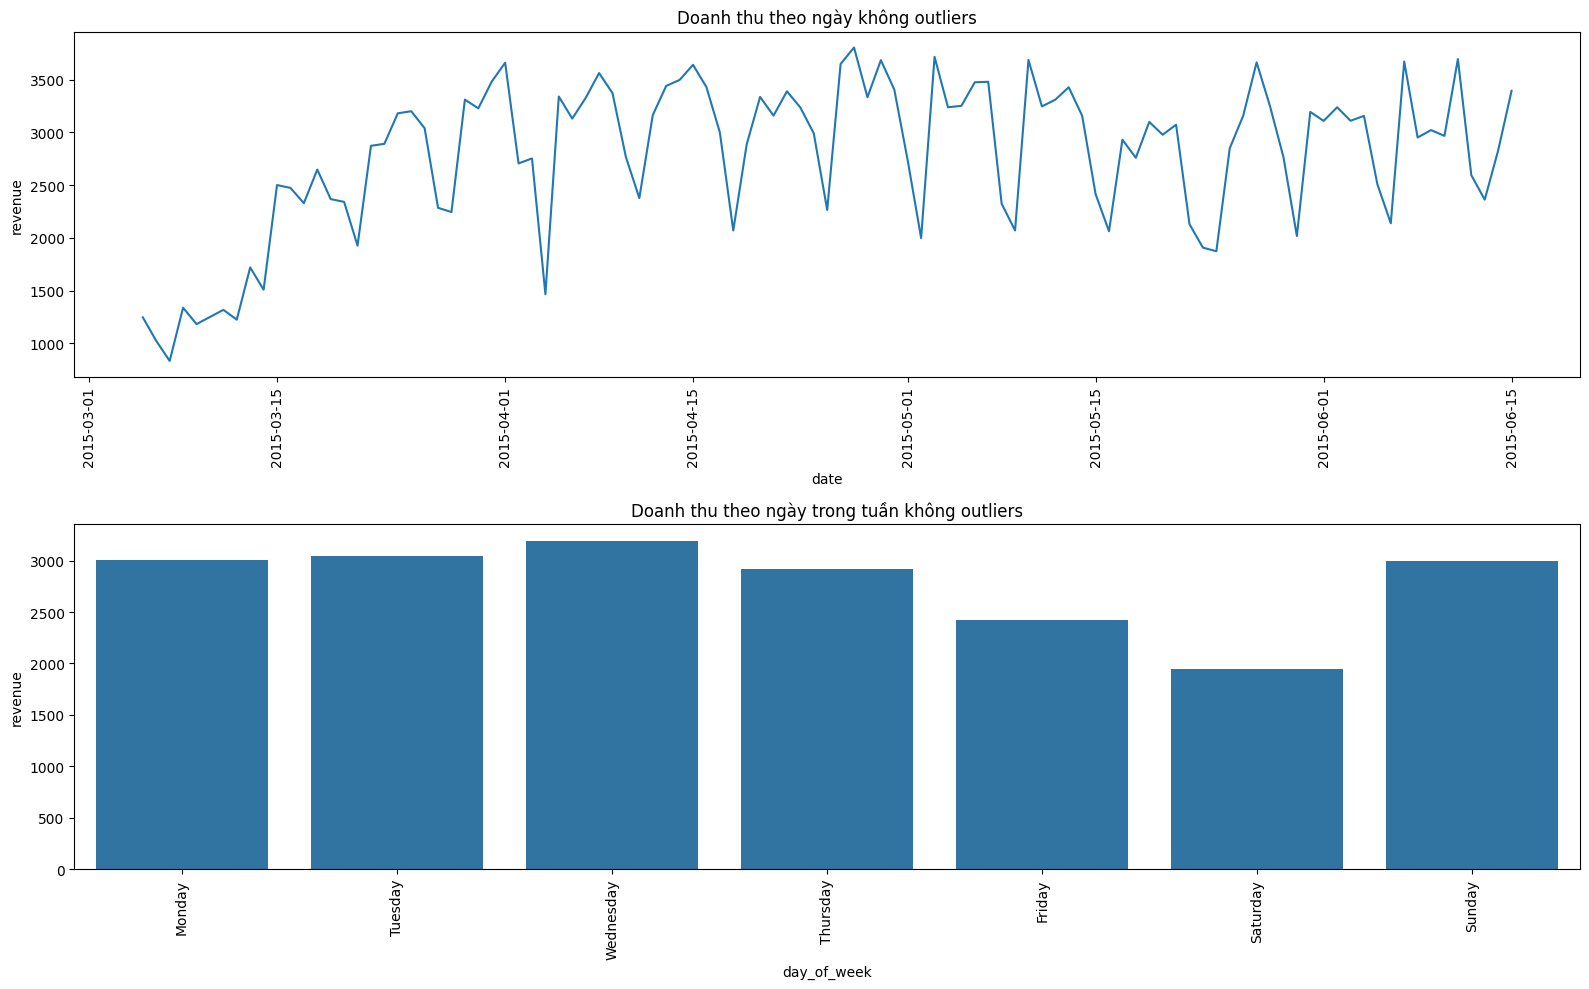

In [18]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=revenue_by_day_non_outliers,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày không outliers")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week_non_outliers,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần không outliers")

plt.tight_layout()
plt.show()

Note: Khoảng thời gian 2 tuần đầu hơi ít so với khoảng thời gian còn lại.
- Data có vấn đề gì không? (Không đủ dữ liệu để tìm nguyên nhân)
- Biểu đồ doanh thu theo ngày có tính chu kỳ, dựa theo biểu đồ doanh thu ngày trong tuần xác định điều đó

Nhận xét: Doanh thu có xu hướng tăng từ thứ 2 tới ths 4 và có xu hướng giảm từ thứ 5 tới thứ 7 và tăng trở lại vào CN

#### 2.1.2.1 Kiểm tra dữ liệu

In [19]:
revenue_by_day

date day_of_week  revenue
0   2015-03-05    Thursday  1393.34
1   2015-03-06      Friday  1196.23
2   2015-03-07    Saturday   916.41
3   2015-03-08      Sunday  1524.00
4   2015-03-09      Monday  1311.75
..         ...         ...      ...
98  2015-06-11    Thursday  4097.40
99  2015-06-12      Friday  3072.31
100 2015-06-13    Saturday  2640.17
101 2015-06-14      Sunday  3110.87
102 2015-06-15      Monday  3955.69

[103 rows x 3 columns]

In [20]:
revenue_day_of_week

day_of_week      revenue
0    Saturday  2276.960000
1      Friday  2745.435333
2    Thursday  3248.174000
3      Sunday  3248.758000
4      Monday  3270.720000
5     Tuesday  3313.574286
6   Wednesday  3467.004286

### 2.1.3 Doanh thu tổng outliers

In [21]:
# Doanh thu tổng theo ngày
revenue_by_day_outliers = outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week_outliers = revenue_by_day_outliers.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()

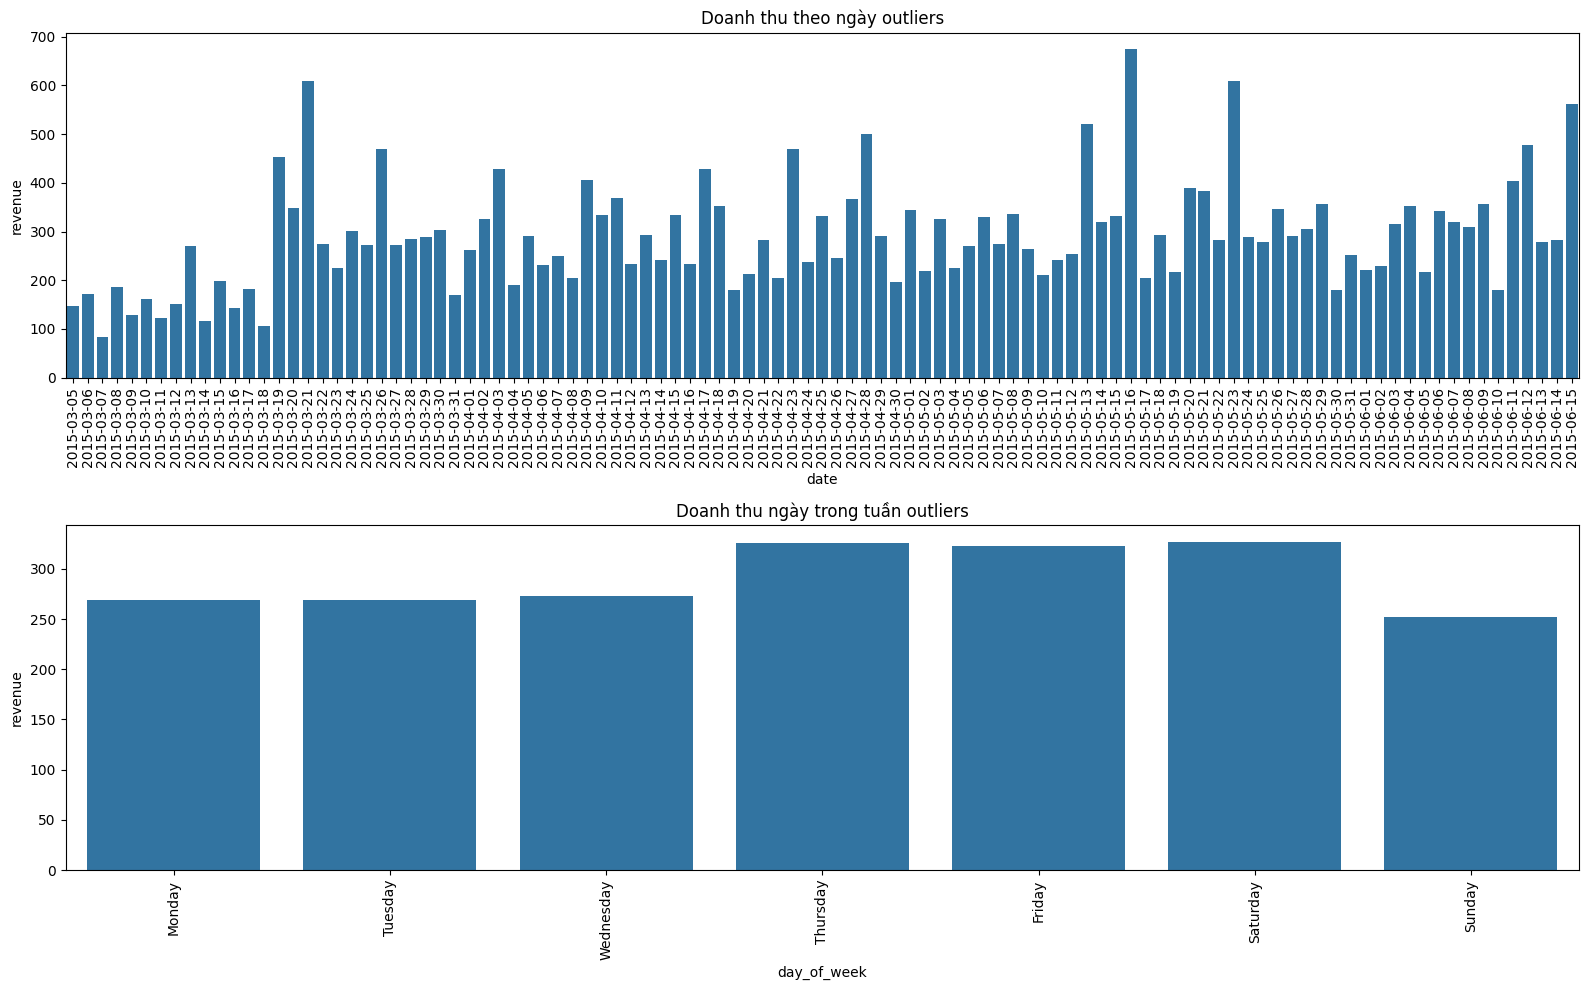

In [22]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day_outliers,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày outliers")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week_outliers,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu ngày trong tuần outliers")

plt.tight_layout()
plt.show()

Note: (giả thuyết)
- Thứ 7 có nhiều outliers
- Có thể thứ 7 khách nhỏ giảm khách lớn tăng 

Note: Outliers thường vào ngày thứ 7 cho thấy có thể có những sự kiện đặc biệt diễn ra trong ngày này như: đặt tiệc, sự kiện, hoặc các chương trình khuyến mãi đặc biệt

Analysis: Để xác nhận giả thuyết này, cần phân tích thêm dữ liệu về:
- số lượng đơn hàng
- doanh thu mỗi đơn hàng
- và loại hình (ăn tại chỗ hoặc mang đi)
được sử dụng vào các ngày thứ 7.

#### 2.1.3.1 Kiểm tra và xác nhận lại dữ liệu ngoại lai

In [23]:
revenue_by_day_outliers.head()

date day_of_week  revenue
0 2015-03-05    Thursday   146.55
1 2015-03-06      Friday   172.55
2 2015-03-07    Saturday    82.25
3 2015-03-08      Sunday   185.48
4 2015-03-09      Monday   128.74

In [24]:
revenue_day_of_week_outliers

day_of_week     revenue
0      Sunday  251.891333
1     Tuesday  268.720000
2      Monday  268.822667
3   Wednesday  273.042857
4      Friday  322.376000
5    Thursday  326.178667
6    Saturday  326.990667

### 2.1.4 Xác nhận giả thuyết sang phần 2.2
Doanh thu tổng có xu hướng tăng từ T2 tới T4 và có xu hướng giảm tới T7, và tăng lại vào CN
- Doanh thu không outliers có xu hướng tương tự như doanh thu tổng
- Doanh thu outliers thì lại có xu hướng hơi ngược, doanh thu các ngày từ T2 tới T4 gần bằng nhau, CN có hơi giảm. Nhưng doanh thu từ T5 tới T7 lại có xu hướng tăng hơn so với các ngày khác trong tuần.

Với outlier được tính theo Quantity thì có thể có một số giả thuyết cần được chú ý:
- Tại sao doanh thu outlier lại tăng vào các ngày từ T5 tới T7?
- Có phải do số lượng món ăn tăng? -> Tính trung bình món ăn mỗi đơn hàng
- Có phải số lượng đơn tăng
- Có phải giá trị món ăn tăng? 
- - Danh mục món ăn
- - Món ăn
- Loại hình ăn uống có sự thay đổi? (Ăn tại chỗ, mang đi)

## 2.2 Kiểm tra dữ liệu các ngày trong tuần
Cần dữ liệu từ ordersale và menuitem để lấy được loại hình ăn uống (tại chỗ, mang đi)

In [25]:
# # Xác định giá trị ngoại lai
# outliers_quantity = df_menuitem[(df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity)].copy()
# non_outliers_quantity = df_menuitem[~((df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity))].copy()

# Check dữ liệu doanh thu tổng, outliers và non_outliers 
print(df_menuitem['SalesAmount'].sum())
print(outliers_quantity['SalesAmount'].sum())
print(non_outliers_quantity['SalesAmount'].sum())
print(outliers_quantity['SalesAmount'].sum() + non_outliers_quantity['SalesAmount'].sum())

316778.81
30028.57
286750.24
316778.81


### 2.2.1 Chuẩn bị dữ liệu

#### 2.2.1.1 Merge dữ liệu

In [26]:
df_ordersale

MD5KEY_ORDERSALE  ChangeReceived  OrderNumber  \
0      00BCB738A1F814DB960C25012E9913DF            0.00           67   
1      03438C257BC2DD0037F35EC8BFC0C8E2            3.46           39   
2      04AEF56CF3130AC1EFAD41C470F5245D            0.00           81   
3      04BBFAD4E73C30EE2EC3B4E52509637C            0.00          159   
4      061AE382DC127057E8ADBBF869CFB361            0.00           51   
...                                 ...             ...          ...   
43223  FBEFF26C8C626C303C191A42C8CCFBDA            0.00         8014   
43224  FC277A831486F1ADD27AE22FF2BDF559            0.03        15972   
43225  FD23743074BCCB6E0847269D09F458AE            0.00        16014   
43226  FD570797AC0A9AFC3953A30EC5355829            0.00         7149   
43227  FF181C8AF4B9B9BD8912B2926464EB08            0.00        16033   

       TaxAmount  MealLocation  TransactionId  StoreNumber       date  
0           0.56             0             67        46673 2015-03-05  
1           0.54             0             39        12631 2015-03-05  
2           0.69             0             79        46673 2015-03-05  
3           1.16             0            159        12631 2015-03-05  
4           0.00             0             51        12631 2015-03-05  
...          ...           ...            ...          ...        ...  
43223       1.58             0           8014        20974 2015-06-15  
43224       0.47             0          15972         4904 2015-06-15  
43225       0.00             1          16014         4904 2015-06-15  
43226       0.00             1           7149        46673 2015-06-15  
43227       0.00             0          16033         4904 2015-06-15  

[43228 rows x 8 columns]

In [27]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [28]:
# Merge dữ liệu ordersale và menuitem
merged_ordersale_menuitem = pd.merge(df_ordersale, df_menuitem, on='MD5KEY_ORDERSALE', how='left')
merged_ordersale_menuitem.head()

MD5KEY_ORDERSALE  ChangeReceived  OrderNumber  TaxAmount_x  \
0  00BCB738A1F814DB960C25012E9913DF            0.00           67         0.56   
1  00BCB738A1F814DB960C25012E9913DF            0.00           67         0.56   
2  03438C257BC2DD0037F35EC8BFC0C8E2            3.46           39         0.54   
3  03438C257BC2DD0037F35EC8BFC0C8E2            3.46           39         0.54   
4  04AEF56CF3130AC1EFAD41C470F5245D            0.00           81         0.69   

   MealLocation  TransactionId  StoreNumber_x     date_x  \
0             0             67          46673 2015-03-05   
1             0             67          46673 2015-03-05   
2             0             39          12631 2015-03-05   
3             0             39          12631 2015-03-05   
4             0             79          46673 2015-03-05   

                    MD5KEY_MENUITEM CategoryDescription  ... AdjustedPrice  \
0  F723AFAEC05500ED00EE7B642DBBEF50            Fountain  ...          1.70   
1  FBDE984CE2674869B840D31AE7E4C35A              6 Inch  ...          4.50   
2  6B19A97889A7B5902E6E7B489F403067              6 Inch  ...          4.25   
3  B54026720FF6611399B7451FCC8DC4B2    Bottled Beverage  ...          1.75   
4  BC939C43F3BEB1DCE24AAD956919832C    Bottled Beverage  ...          1.90   

  DiscountAmount  Price  Quantity          PLU     Id     date_y  SalesAmount  \
0            0.0   1.70       1.0  212000126.0  280.0 2015-03-05         1.70   
1            0.0   4.50       1.0  121000004.0    2.0 2015-03-05         4.50   
2            0.0   4.25       1.0  121000006.0   75.0 2015-03-05         4.25   
3            0.0   1.75       1.0  221000135.0  278.0 2015-03-05         1.75   
4            0.0   1.90       1.0  221000134.0  365.0 2015-03-05         1.90   

   day_of_week  DiscountPercentage  
0     Thursday                 0.0  
1     Thursday                 0.0  
2     Thursday                 0.0  
3     Thursday                 0.0  
4     Thursday                 0.0  

[5 rows x 24 columns]

In [29]:
# Kiểm tra doanh thu tổng trước và sau merge 
print(df_menuitem['SalesAmount'].sum())
print(merged_ordersale_menuitem['SalesAmount'].sum())

316778.81
316778.80999999994


#### 2.2.1.2 Groupby dữ liệu theo đơn hàng

In [30]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [31]:
# Group các trường cần thiết để tính doanh thu, số lượng đơn hàng, loại hình
merged_ordersale_menuitem_groupby = merged_ordersale_menuitem.groupby(['MD5KEY_ORDERSALE', 'MD5KEY_MENUITEM', 'date_x', 'day_of_week', 'StoreNumber_x', 'MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

merged_ordersale_menuitem_groupby

MD5KEY_ORDERSALE                   MD5KEY_MENUITEM  \
0      00040FB2079EE37A1A3347134FDA1222  9C416C59949FFD99FFCC7060E02C0246   
1      000487D84122ECFC7C2B0681D7847D07  9ED95B86B85E6DC61447D01E8D035D7B   
2      000487D84122ECFC7C2B0681D7847D07  AE80E5C1351D5609F4FA48BA7319D901   
3      0006541E961609F6EA9B93AF996791FA  9BAC6F747424C60B774C8EB40CA8C537   
4      0007198A6EA115A618FB1F7A47DA5A94  0E10A6ECBF9A76AE0EB48C433CAA955E   
...                                 ...                               ...   
91415  FFF9C0AFD57C0B07E3ADE021C41BC222  EC2C92C3D148A710B2DE31547AF8489A   
91416  FFFB7296078113301047E98795ED0836  48C426DE0F09A23F936E72819BD921AA   
91417  FFFB7296078113301047E98795ED0836  57E183ED1E3E0092971305B7FD3ACE39   
91418  FFFB7296078113301047E98795ED0836  6F69420279CEDDFB3776138F18BEAAC6   
91419  FFFC4FB2B89C83C2ECF5C05A098CA189  E1DB565D3101D985C5A9B164968F4066   

          date_x day_of_week  StoreNumber_x  MealLocation  Quantity  \
0     2015-04-03      Friday          12631             0       1.0   
1     2015-04-03      Friday          12631             0       2.0   
2     2015-04-03      Friday          12631             0       2.0   
3     2015-03-19    Thursday           4904             1       1.0   
4     2015-04-16    Thursday          12631             0       1.0   
...          ...         ...            ...           ...       ...   
91415 2015-03-21    Saturday           4904             0       1.0   
91416 2015-04-28     Tuesday           4904             1       1.0   
91417 2015-04-28     Tuesday           4904             1       1.0   
91418 2015-04-28     Tuesday           4904             1       1.0   
91419 2015-03-18   Wednesday           4904             0       1.0   

       SalesAmount  
0             6.00  
1            12.00  
2             2.20  
3             4.25  
4             6.00  
...            ...  
91415         6.75  
91416         0.95  
91417         3.86  
91418         1.19  
91419         5.00  

[91420 rows x 8 columns]

### 2.2.2 Doanh thu trung bình mỗi đơn hàng

In [32]:
# Group by date
groupby_day_revenue = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(revenue=('SalesAmount', 'mean')).reset_index()

# Group day_of_week
groupby_day_of_week_revenue = groupby_day_revenue.groupby('day_of_week').agg(avg_revenue=('revenue', 'mean')).reset_index()

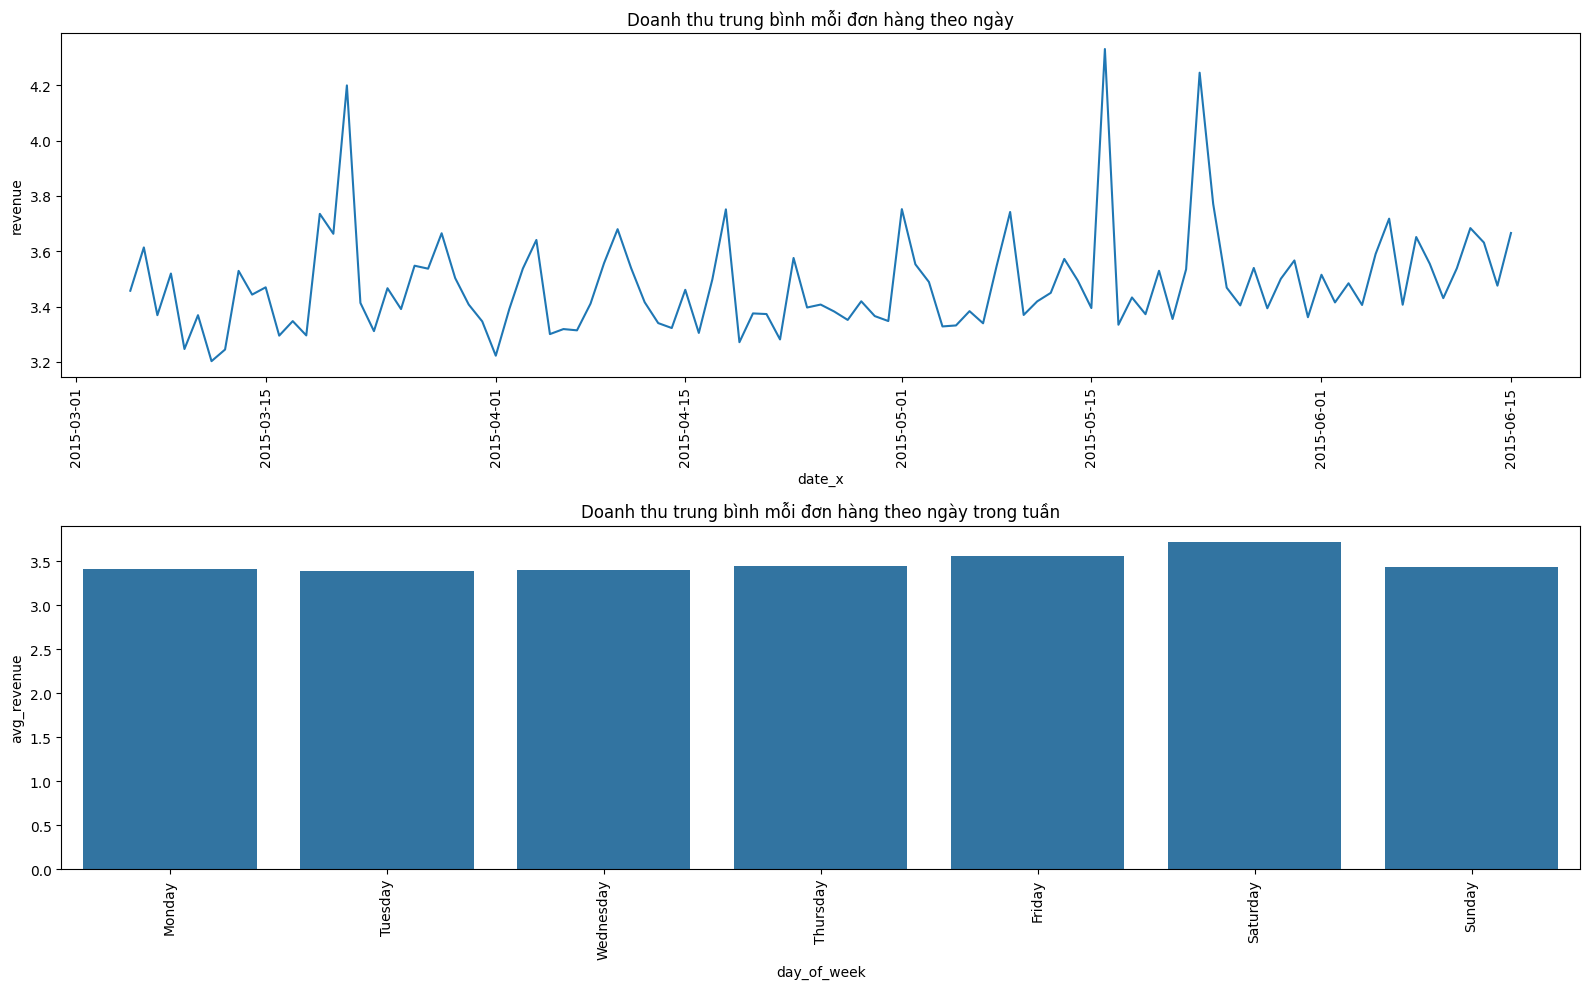

In [33]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_revenue,
             x='date_x',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_revenue,
             x='day_of_week',
             y='avg_revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.3 Số lượng đơn hàng

In [34]:
merged_ordersale_menuitem_groupby.head()

MD5KEY_ORDERSALE                   MD5KEY_MENUITEM  \
0  00040FB2079EE37A1A3347134FDA1222  9C416C59949FFD99FFCC7060E02C0246   
1  000487D84122ECFC7C2B0681D7847D07  9ED95B86B85E6DC61447D01E8D035D7B   
2  000487D84122ECFC7C2B0681D7847D07  AE80E5C1351D5609F4FA48BA7319D901   
3  0006541E961609F6EA9B93AF996791FA  9BAC6F747424C60B774C8EB40CA8C537   
4  0007198A6EA115A618FB1F7A47DA5A94  0E10A6ECBF9A76AE0EB48C433CAA955E   

      date_x day_of_week  StoreNumber_x  MealLocation  Quantity  SalesAmount  
0 2015-04-03      Friday          12631             0       1.0         6.00  
1 2015-04-03      Friday          12631             0       2.0        12.00  
2 2015-04-03      Friday          12631             0       2.0         2.20  
3 2015-03-19    Thursday           4904             1       1.0         4.25  
4 2015-04-16    Thursday          12631             0       1.0         6.00

In [35]:
# Group by date
groupby_day_order = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(total_order=('MD5KEY_ORDERSALE', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_order = groupby_day_order.groupby('day_of_week').agg(avg_order=('total_order', 'mean')).reset_index()

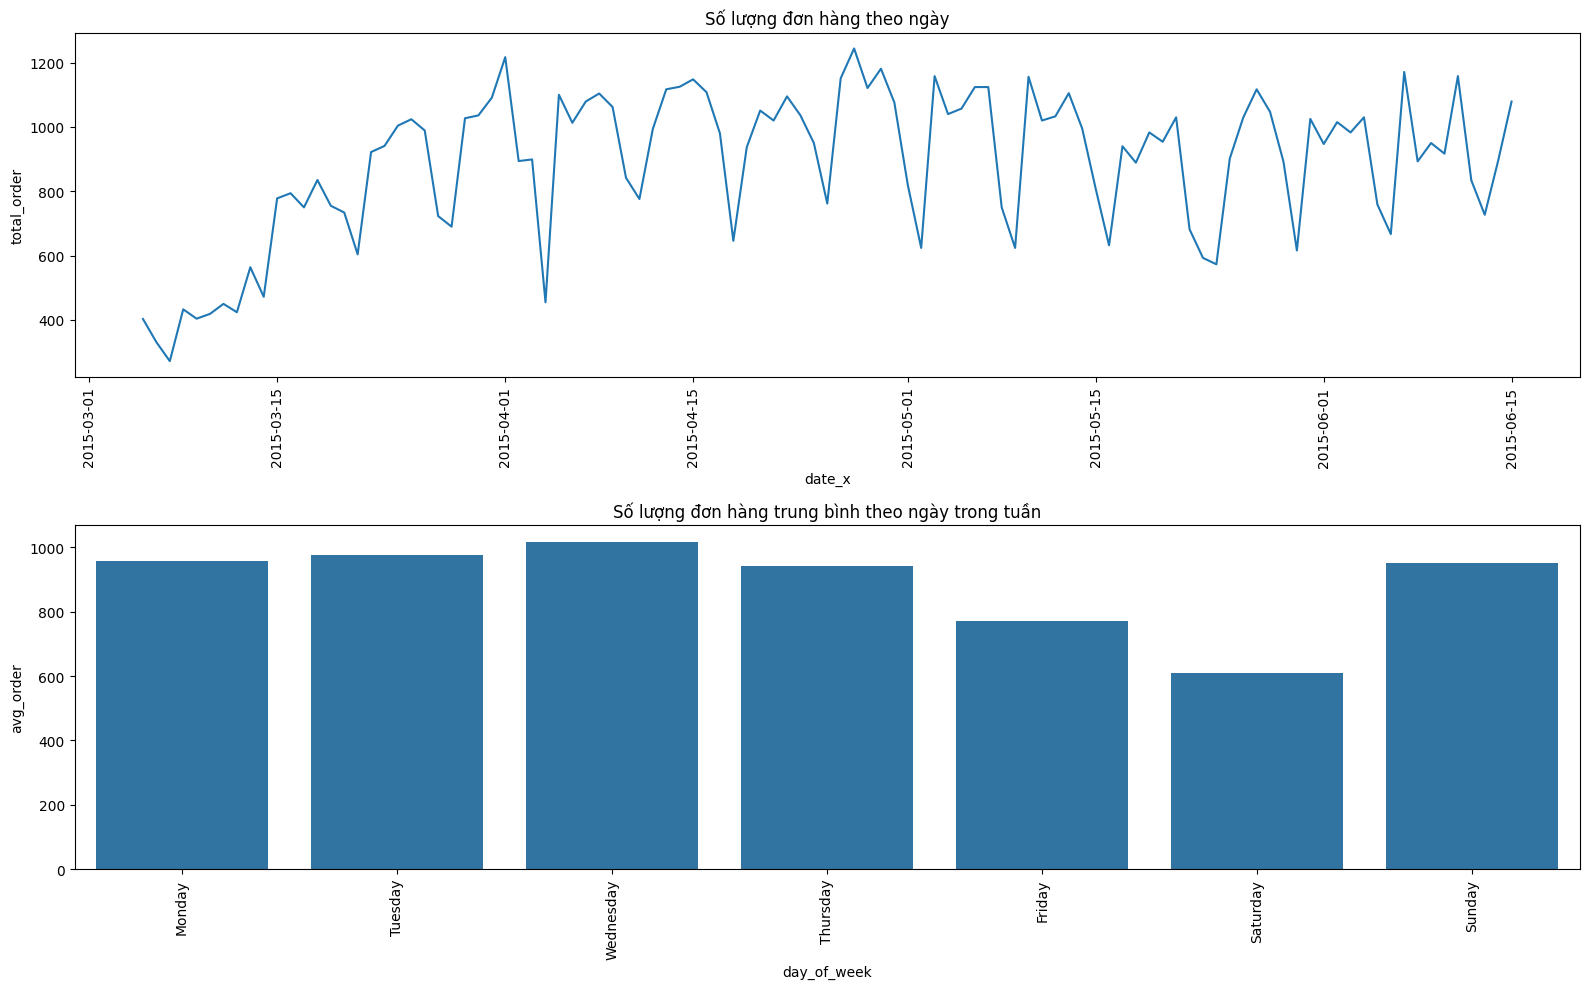

In [36]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_order,
             x='date_x',
             y='total_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_order,
             x='day_of_week',
             y='avg_order',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng đơn hàng trung bình theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 A.Số món ăn trong mỗi đơn hàng

In [37]:
merged_ordersale_menuitem_groupby.columns

Index(['MD5KEY_ORDERSALE', 'MD5KEY_MENUITEM', 'date_x', 'day_of_week',
       'StoreNumber_x', 'MealLocation', 'Quantity', 'SalesAmount'],
      dtype='object')

In [38]:
# Group by date
groupby_day_item = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(quantity=('MD5KEY_MENUITEM', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_item = groupby_day_item.groupby('day_of_week').agg(avg_quantity=('quantity', 'mean')).reset_index()

In [39]:
groupby_day_item
# groupby_day_of_week_item

date_x day_of_week  quantity
0   2015-03-05    Thursday       403
1   2015-03-06      Friday       331
2   2015-03-07    Saturday       272
3   2015-03-08      Sunday       433
4   2015-03-09      Monday       404
..         ...         ...       ...
98  2015-06-11    Thursday      1158
99  2015-06-12      Friday       834
100 2015-06-13    Saturday       727
101 2015-06-14      Sunday       895
102 2015-06-15      Monday      1079

[103 rows x 3 columns]

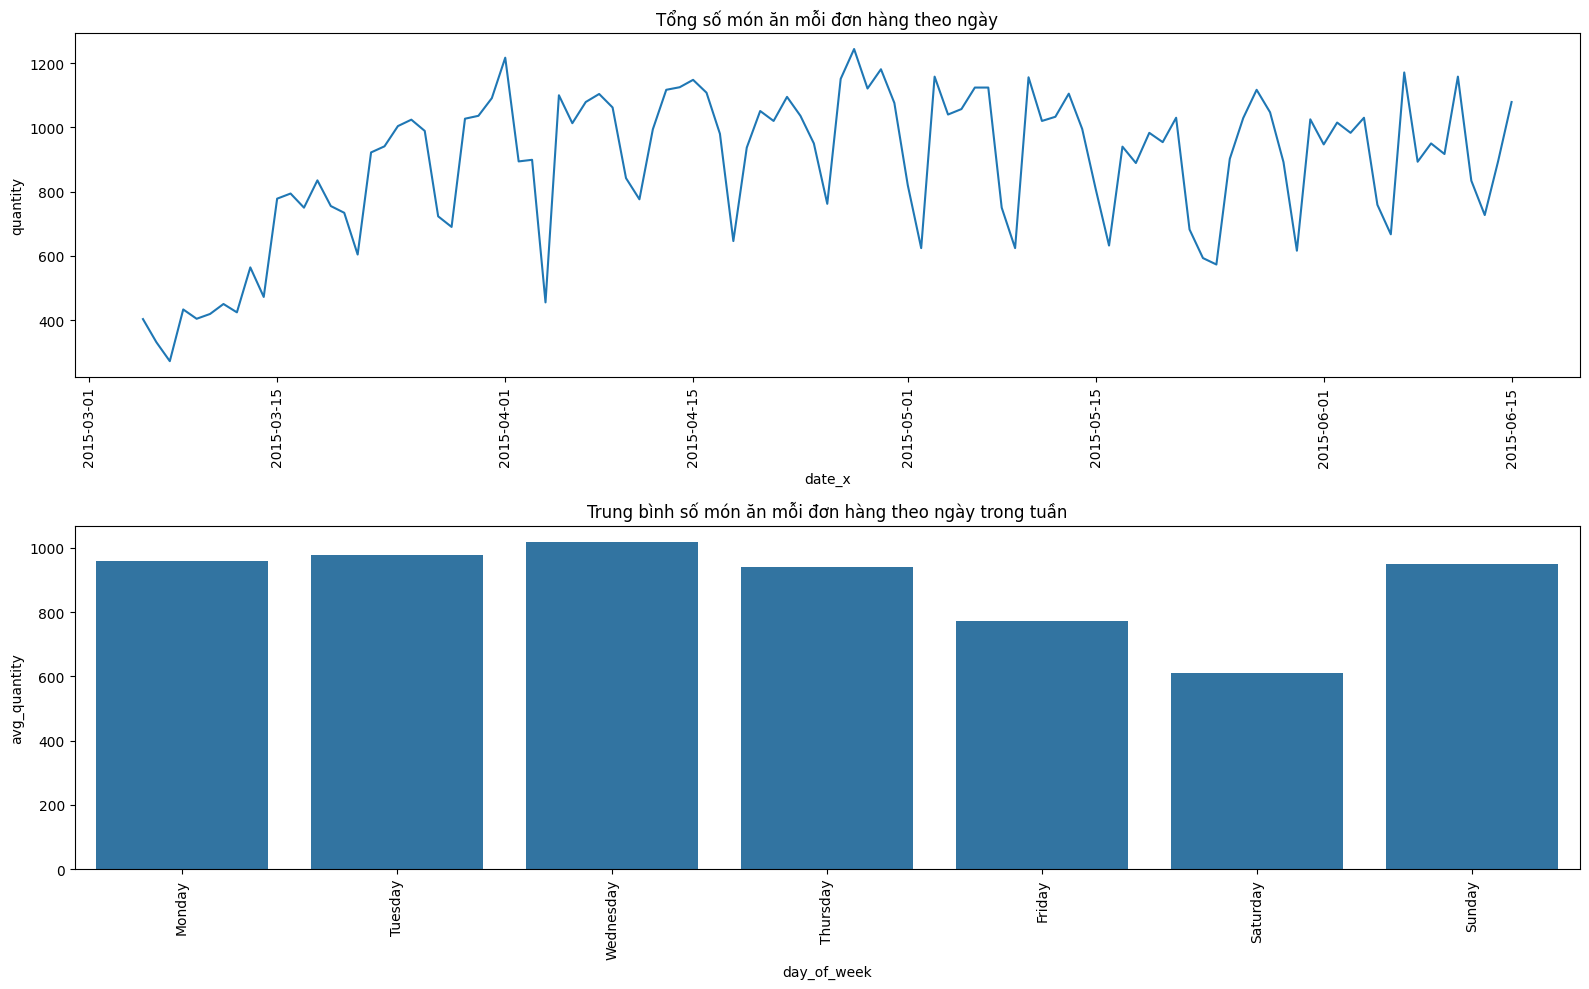

In [40]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_item,
             x='date_x',
             y='quantity')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng số món ăn mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_item,
             x='day_of_week',
             y='avg_quantity',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình số món ăn mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 B.Số lượng món ăn mỗi đơn hàng

In [41]:
# Group by date
groupby_day_quantity = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(quantity=('Quantity', 'sum')).reset_index()

# Group day_of_week
groupby_day_of_week_quantity = groupby_day_quantity.groupby('day_of_week').agg(avg_quantity=('quantity', 'mean')).reset_index()

In [42]:
groupby_day_quantity

date_x day_of_week  quantity
0   2015-03-05    Thursday     444.0
1   2015-03-06      Friday     367.0
2   2015-03-07    Saturday     302.0
3   2015-03-08      Sunday     487.0
4   2015-03-09      Monday     437.0
..         ...         ...       ...
98  2015-06-11    Thursday    1255.0
99  2015-06-12      Friday     956.0
100 2015-06-13    Saturday     806.0
101 2015-06-14      Sunday     967.0
102 2015-06-15      Monday    1160.0

[103 rows x 3 columns]

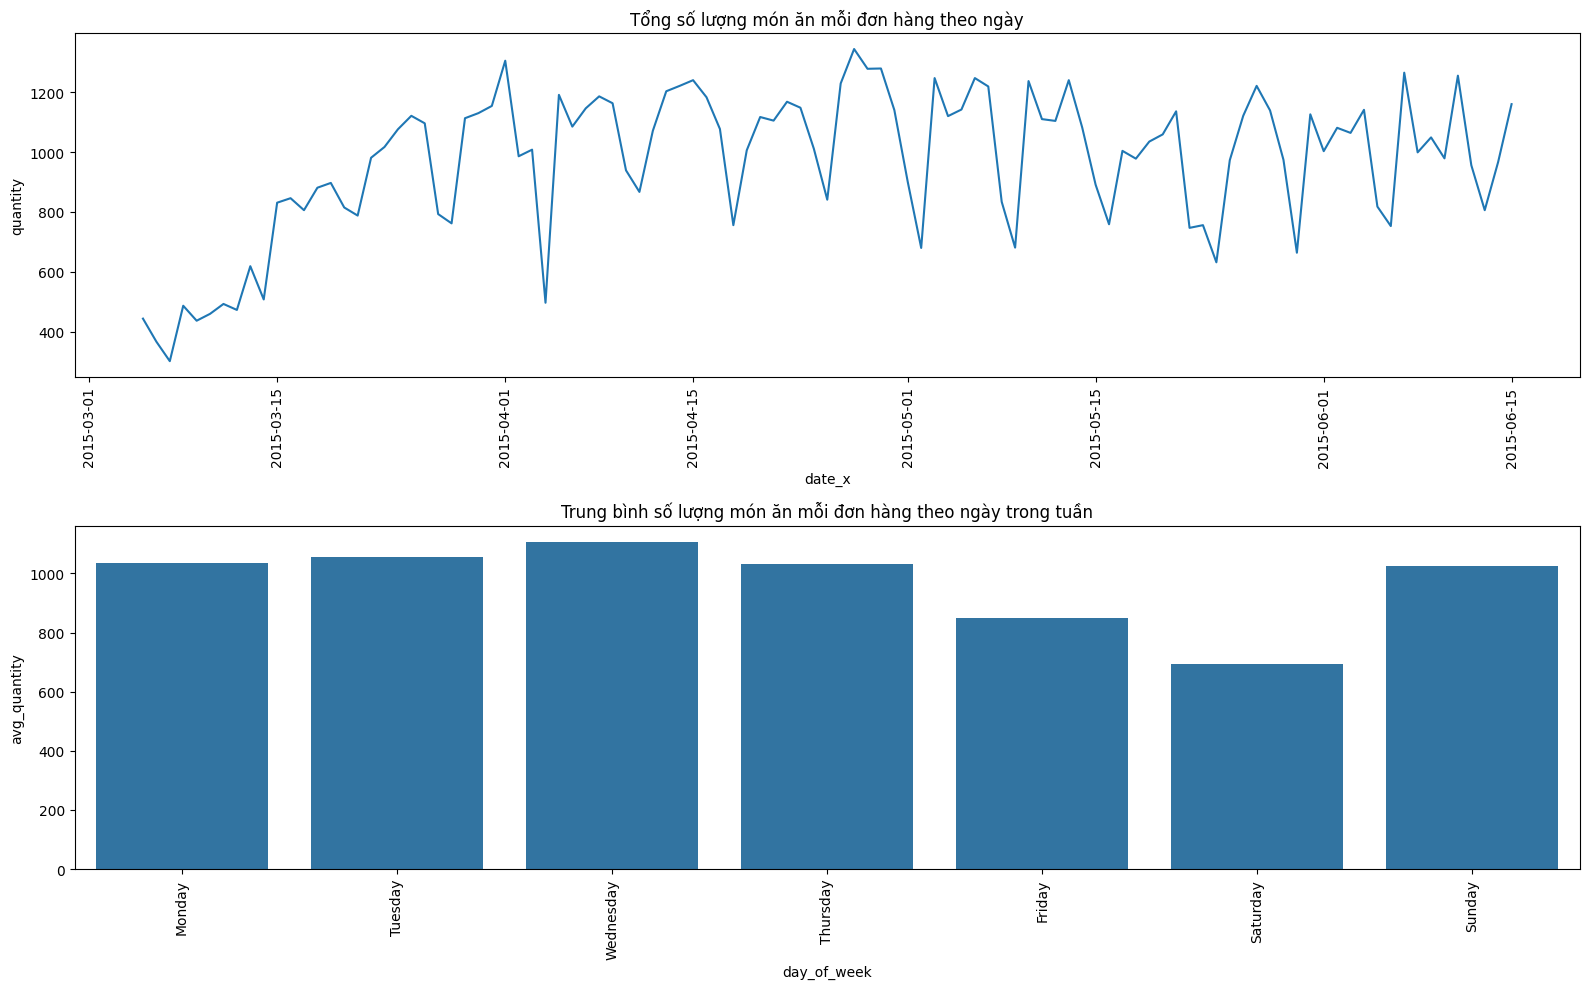

In [43]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_quantity,
             x='date_x',
             y='quantity')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng số lượng món ăn mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_quantity,
             x='day_of_week',
             y='avg_quantity',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình số lượng món ăn mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 Loại hình đơn hàng (ăn tại chỗ, mang đi)

In [44]:
# Group by date
groupby_day_meallocation = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week', 'MealLocation']).agg(quantity=('MealLocation', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_meallocation = groupby_day_meallocation.groupby(['day_of_week', 'MealLocation']).agg(avg_quantity=('quantity', 'mean')).reset_index()

#### 2.2.4.2 Thêm cột MealLocationText
Làm rõ ngữ cảnh

In [45]:
# Add column MealLocationText
groupby_day_meallocation['MealLocationText'] = groupby_day_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')
groupby_day_of_week_meallocation['MealLocationText'] = groupby_day_of_week_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')

In [46]:
groupby_day_meallocation.head()

date_x day_of_week  MealLocation  quantity MealLocationText
0 2015-03-05    Thursday             0       388              Eat
1 2015-03-05    Thursday             1        15             ToGo
2 2015-03-06      Friday             0       315              Eat
3 2015-03-06      Friday             1        16             ToGo
4 2015-03-07    Saturday             0       257              Eat

In [47]:
groupby_day_of_week_meallocation.head()

day_of_week  MealLocation  avg_quantity MealLocationText
0      Friday             0    621.000000              Eat
1      Friday             1    150.266667             ToGo
2      Monday             0    796.733333              Eat
3      Monday             1    161.266667             ToGo
4    Saturday             0    483.666667              Eat

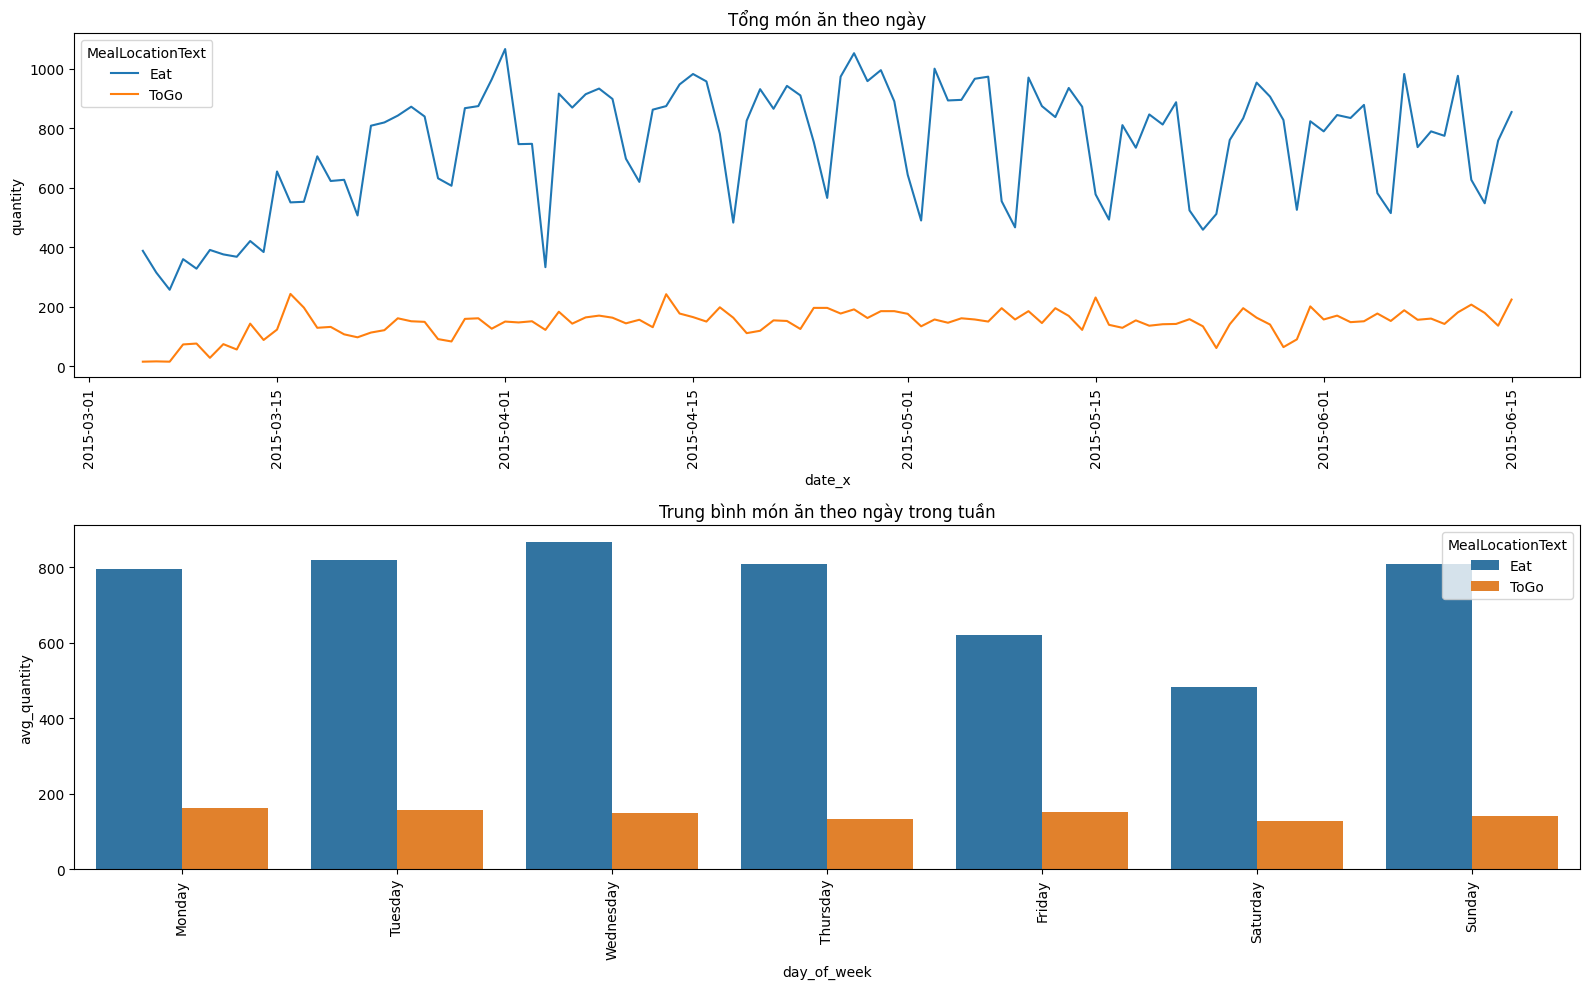

In [48]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_meallocation,
             x='date_x',
             y='quantity',
             hue='MealLocationText')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_meallocation,
             x='day_of_week',
             y='avg_quantity',
             hue='MealLocationText',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

Note: Từ các phân tích số lượng đơn hàng, số lượng món ăn mỗi đơn hàng, loại hình đơn hàng đều có tính chu kỳ tăng dần từ thứ hai tới thứ 4 và giảm dần tới thứ 7 rồi tăng lại từ chủ nhật. Ngoại trừ phân tích doanh thu trung bình mỗi đơn, điều này cho thấy có thể các đơn hàng ngày thứ 7 có các món có giá trị cao trong đơn hàng.

Nextstep:
- Phân tích thêm từng cửa hàng để xem có phải là pattern chung không.
- Phân tích các món ăn được đặt nhiều ở thứ 7 so với các món ăn của các ngày trong tuần (danh mục món ăn)

Note: thêm ***
- Trung bình món ăn cho mỗi đơn hàng giữa Eat, ToGo

### 2.2.5 A. Giá trung bình của món ăn trong đơn hàng

In [49]:
# Groupby day
group_day_order_avg = merged_ordersale_menuitem_groupby.groupby(['MD5KEY_ORDERSALE', 'date_x', 'day_of_week', 'MealLocation']).agg(
  total_item=('MD5KEY_MENUITEM', 'count'),
  total_SalesAmount=('SalesAmount', 'sum')).reset_index()

group_day_order_avg['AverageItemPricePerOrder'] = group_day_order_avg['total_SalesAmount'] /group_day_order_avg['total_item']
group_day_order_avg

MD5KEY_ORDERSALE     date_x day_of_week  MealLocation  \
0      00040FB2079EE37A1A3347134FDA1222 2015-04-03      Friday             0   
1      000487D84122ECFC7C2B0681D7847D07 2015-04-03      Friday             0   
2      0006541E961609F6EA9B93AF996791FA 2015-03-19    Thursday             1   
3      0007198A6EA115A618FB1F7A47DA5A94 2015-04-16    Thursday             0   
4      0009AF6BC70525EA7865AB795C651219 2015-04-22   Wednesday             0   
...                                 ...        ...         ...           ...   
40616  FFF4B340CBD214BD2A0C12944DD6FC4C 2015-04-25    Saturday             1   
40617  FFF4B38DC800DE5784EC2F27909AB4B9 2015-04-09    Thursday             0   
40618  FFF9C0AFD57C0B07E3ADE021C41BC222 2015-03-21    Saturday             0   
40619  FFFB7296078113301047E98795ED0836 2015-04-28     Tuesday             1   
40620  FFFC4FB2B89C83C2ECF5C05A098CA189 2015-03-18   Wednesday             0   

       total_item  total_SalesAmount  AverageItemPricePerOrder  
0               1               6.00                  6.000000  
1               2              14.20                  7.100000  
2               1               4.25                  4.250000  
3               1               6.00                  6.000000  
4               2               0.00                  0.000000  
...           ...                ...                       ...  
40616           1               5.50                  5.500000  
40617           3               9.25                  3.083333  
40618           1               6.75                  6.750000  
40619           3               6.00                  2.000000  
40620           1               5.00                  5.000000  

[40621 rows x 7 columns]

In [50]:
# Groupby day_of_week
group_day_of_week_order_avg = group_day_order_avg.groupby(['day_of_week', 'MealLocation']).agg(
  total_item=('total_item', 'sum'),
  total_SalesAmount=('total_SalesAmount', 'sum')).reset_index()

group_day_of_week_order_avg['AverageItemPricePerOrder'] = group_day_of_week_order_avg['total_SalesAmount'] /group_day_of_week_order_avg['total_item']
group_day_of_week_order_avg

day_of_week  MealLocation  total_item  total_SalesAmount  \
0       Friday             0        9315           33312.69   
1       Friday             1        2254            7868.84   
2       Monday             0       11951           41087.62   
3       Monday             1        2419            7973.18   
4     Saturday             0        7255           26991.25   
5     Saturday             1        1905            7163.15   
6       Sunday             0       12133           41822.96   
7       Sunday             1        2127            6908.41   
8     Thursday             0       12123           41939.09   
9     Thursday             1        2008            6783.52   
10     Tuesday             0       11490           39682.88   
11     Tuesday             1        2186            6707.16   
12   Wednesday             0       12158           41898.78   
13   Wednesday             1        2096            6639.28   

    AverageItemPricePerOrder  
0                   3.576242  
1                   3.491056  
2                   3.438007  
3                   3.296064  
4                   3.720365  
5                   3.760184  
6                   3.447042  
7                   3.247960  
8                   3.459465  
9                   3.378247  
10                  3.453688  
11                  3.068234  
12                  3.446190  
13                  3.167595

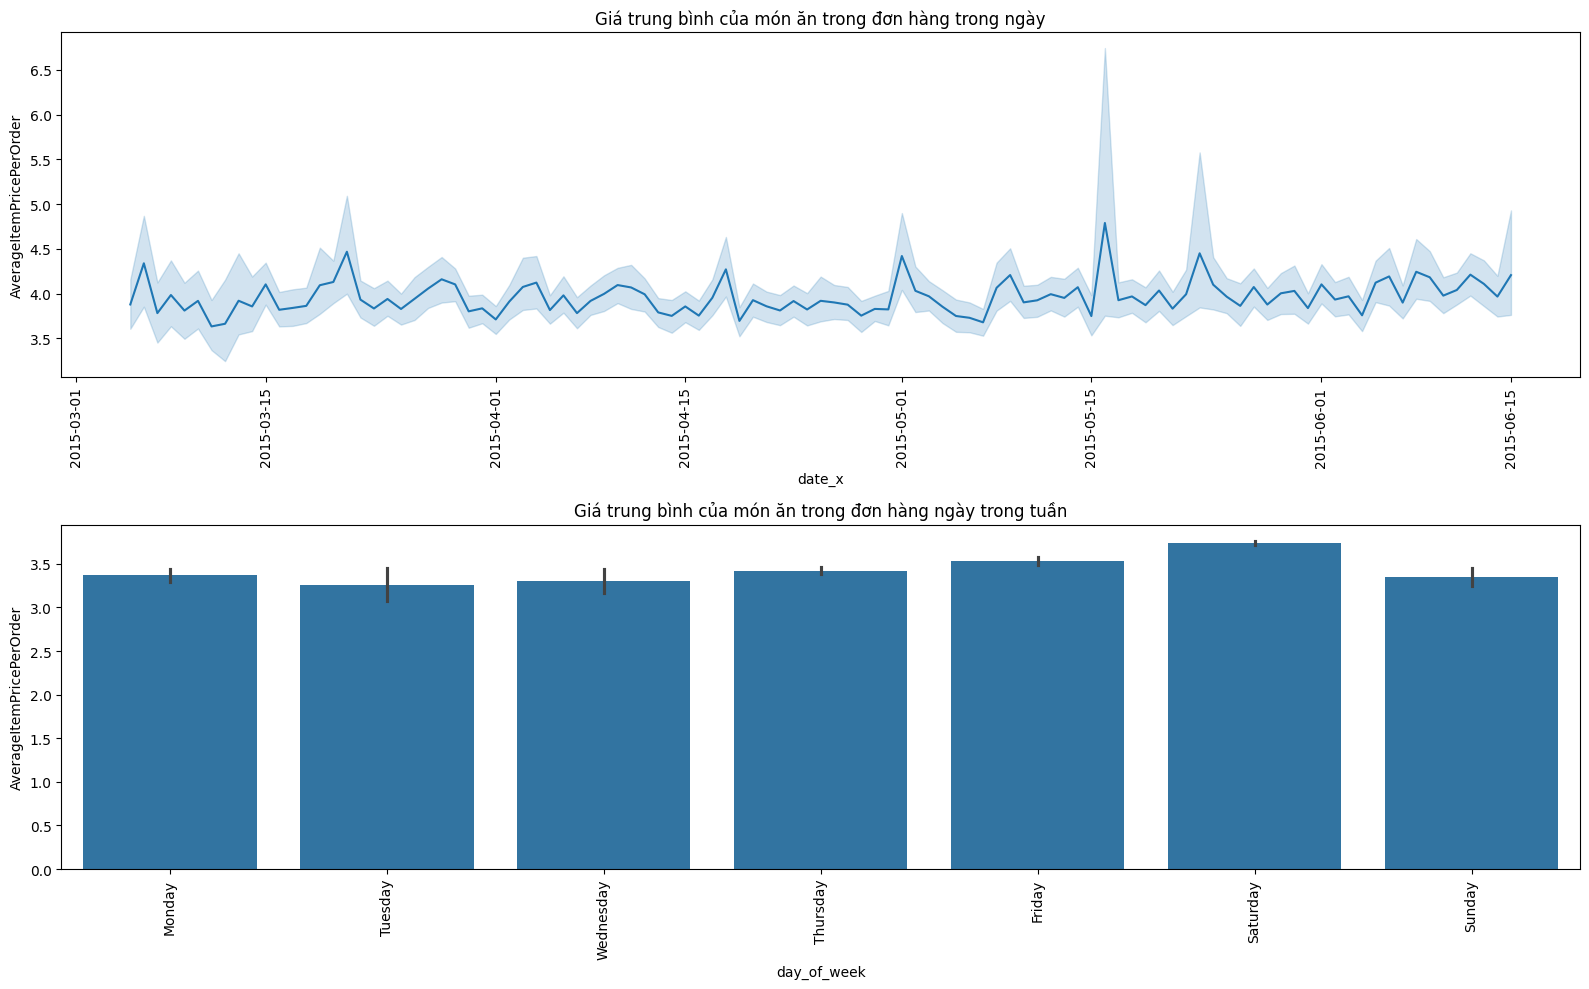

In [51]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=group_day_order_avg,
             x='date_x',
             y='AverageItemPricePerOrder')
plt.xticks(rotation=90, ha='center')
plt.title("Giá trung bình của món ăn trong đơn hàng trong ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=group_day_of_week_order_avg,
             x='day_of_week',
             y='AverageItemPricePerOrder',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Giá trung bình của món ăn trong đơn hàng ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.5 B. Số món ăn trung bình cho mỗi đơn hàng giữa Eat, ToGo

In [52]:
# Group by date
group_day_order_avg_meallocation = group_day_order_avg.groupby(['date_x', 'day_of_week', 'MealLocation']).agg(quantity=('MealLocation', 'count')).reset_index()

# Group day_of_week
group_day_of_week_order_avg_meallocation = group_day_order_avg_meallocation.groupby(['day_of_week', 'MealLocation']).agg(avg_quantity=('quantity', 'mean')).reset_index()

In [53]:
# Add column MealLocationText
group_day_order_avg_meallocation['MealLocationText'] = groupby_day_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')
group_day_of_week_order_avg_meallocation['MealLocationText'] = groupby_day_of_week_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')

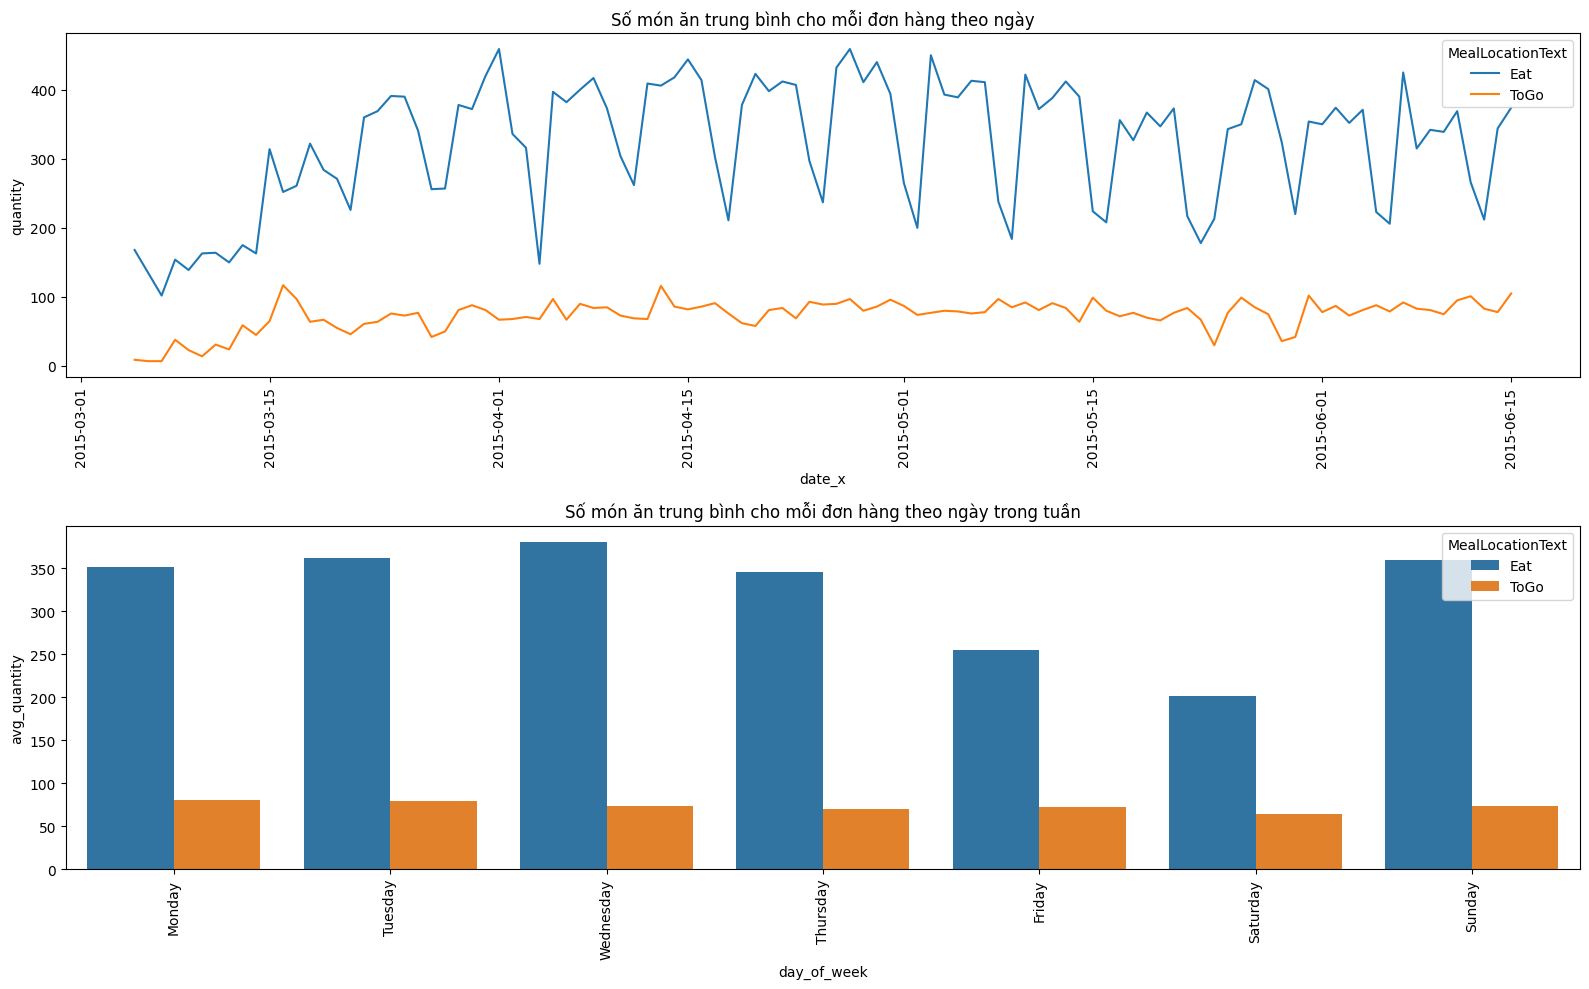

In [54]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=group_day_order_avg_meallocation,
             x='date_x',
             y='quantity',
             hue='MealLocationText')
plt.xticks(rotation=90, ha='center')
plt.title("Số món ăn trung bình cho mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=group_day_of_week_order_avg_meallocation,
             x='day_of_week',
             y='avg_quantity',
             hue='MealLocationText',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Số món ăn trung bình cho mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.5 Top các món ăn được đặt theo các ngày trong tuần

In [55]:
pd.options.display.float_format = '{:.2f}'.format
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

#### 2.2.5.1 Kiểm tra danh mục món ăn ảnh hưởng tới doanh thu

In [56]:
# Groupby day CategoryDescription
groupby_day_CategoryDescription = df_menuitem.groupby(['date', 'day_of_week', 'CategoryDescription'], observed=True).agg(
  price=('Price', 'mean'),
  quantity=('Quantity', 'sum'),
  revenue=('SalesAmount', 'sum')
).sort_values(by='revenue', ascending=False).reset_index()

print(groupby_day_CategoryDescription['revenue'].sum())

groupby_day_CategoryDescription['Percentage'] = groupby_day_CategoryDescription['revenue'] / groupby_day_CategoryDescription['revenue'].sum() * 100

groupby_day_CategoryDescription

316778.80999999994


date day_of_week CategoryDescription  price  quantity  revenue  \
0    2015-06-11    Thursday            Footlong   6.83       307  2044.08   
1    2015-05-27   Wednesday            Footlong   6.74       312  2040.19   
2    2015-04-27      Monday            Footlong   6.53       331  2038.53   
3    2015-05-03      Sunday            Footlong   6.60       316  2037.09   
4    2015-04-26      Sunday            Footlong   6.41       332  2006.35   
...         ...         ...                 ...    ...       ...      ...   
1318 2015-04-20      Monday          Other Misc   0.78         2     1.20   
1319 2015-03-06      Friday          Other Misc   1.25         1     1.16   
1320 2015-06-10   Wednesday          Other Misc   1.50         1     1.15   
1321 2015-04-27      Monday          Other Misc   1.50         1     1.15   
1322 2015-03-15      Sunday          Other Misc   1.25         1     1.13   

      Percentage  
0           0.65  
1           0.64  
2           0.64  
3           0.64  
4           0.63  
...          ...  
1318        0.00  
1319        0.00  
1320        0.00  
1321        0.00  
1322        0.00  

[1323 rows x 7 columns]

In [57]:
df_menuitem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91420 entries, 0 to 91419
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   MD5KEY_MENUITEM        91420 non-null  object        
 1   MD5KEY_ORDERSALE       91420 non-null  object        
 2   CategoryDescription    91420 non-null  object        
 3   DepartmentDescription  91420 non-null  object        
 4   Description            91420 non-null  object        
 5   StoreNumber            91420 non-null  int64         
 6   TaxAmount              91420 non-null  float64       
 7   AdjustedPrice          91420 non-null  float64       
 8   DiscountAmount         91420 non-null  float64       
 9   Price                  91420 non-null  float64       
 10  Quantity               91420 non-null  int64         
 11  PLU                    91420 non-null  int64         
 12  Id                     91420 non-null  int64         
 13  d

In [58]:
# Groupby day of week CategoryDescription
groupby_day_of_week_CategoryDescription = groupby_day_CategoryDescription.groupby(['day_of_week', 'CategoryDescription'], observed=True).agg(
  price=('price', 'mean'),
  quantity=('quantity', 'sum'),
  revenue=('revenue', 'sum'),
  avg_quantity=('quantity', 'mean'),
  avg_revenue=('revenue', 'mean')
).sort_values(by='revenue', ascending=False).reset_index()

print(groupby_day_of_week_CategoryDescription['revenue'].sum())

groupby_day_of_week_CategoryDescription['Percentage'] = groupby_day_of_week_CategoryDescription['revenue'] / groupby_day_of_week_CategoryDescription['revenue'].sum() * 100

groupby_day_of_week_CategoryDescription

316778.81


day_of_week CategoryDescription  price  quantity  revenue  avg_quantity  \
0        Sunday            Footlong   6.64      3749 24102.56        249.93   
1     Wednesday            Footlong   6.66      3754 24059.53        268.14   
2      Thursday            Footlong   6.69      3708 23790.64        247.20   
3        Monday            Footlong   6.66      3680 23654.43        245.33   
4       Tuesday            Footlong   6.63      3552 22683.29        253.71   
..          ...                 ...    ...       ...      ...           ...   
97       Monday        Hot Beverage   1.60        26    41.09          2.36   
98       Sunday          Other Misc   1.47        30    41.01          2.50   
99       Friday        Hot Beverage   1.58        23    35.64          2.09   
100   Wednesday        Hot Beverage   1.60        19    29.81          1.73   
101    Saturday        Hot Beverage   1.58        18    27.97          1.64   

     avg_revenue  Percentage  
0        1606.84        7.61  
1        1718.54        7.60  
2        1586.04        7.51  
3        1576.96        7.47  
4        1620.24        7.16  
..           ...         ...  
97          3.74        0.01  
98          3.42        0.01  
99          3.24        0.01  
100         2.71        0.01  
101         2.54        0.01  

[102 rows x 8 columns]

In [59]:

groupby_day_of_week_CategoryDescription_total = groupby_day_of_week_CategoryDescription.groupby('CategoryDescription').agg(quantity=('quantity', 'sum'), revenue=('revenue', 'sum')).reset_index()
groupby_day_of_week_CategoryDescription_total['percentage_revenue'] = groupby_day_of_week_CategoryDescription_total['revenue'] / groupby_day_of_week_CategoryDescription_total['revenue'].sum() * 100
groupby_day_of_week_CategoryDescription_total.sort_values('percentage_revenue', ascending=False)

CategoryDescription  quantity   revenue  percentage_revenue
7             Footlong     24871 159278.80               50.28
0               6 Inch     18753  78099.04               24.65
8             Fountain     12331  18574.66                5.86
2     Bottled Beverage      9530  16766.57                5.29
5                Chips     15404  16288.03                5.14
6              Cookies      9140   7788.56                2.46
1               Add On      7015   7379.07                2.33
13               Salad      1086   6836.00                2.16
14               Soups       659   1570.84                0.50
3            Cash Card        77   1229.00                0.39
10       Other Carrier       282    867.02                0.27
12               Pizza       176    740.64                0.23
4             Catering        17    643.00                0.20
11          Other Misc       313    423.54                0.13
9         Hot Beverage       187    294.04                0.09

##### 2.2.5.1.1 Số lượng món ăn được đặt mỗi danh mục

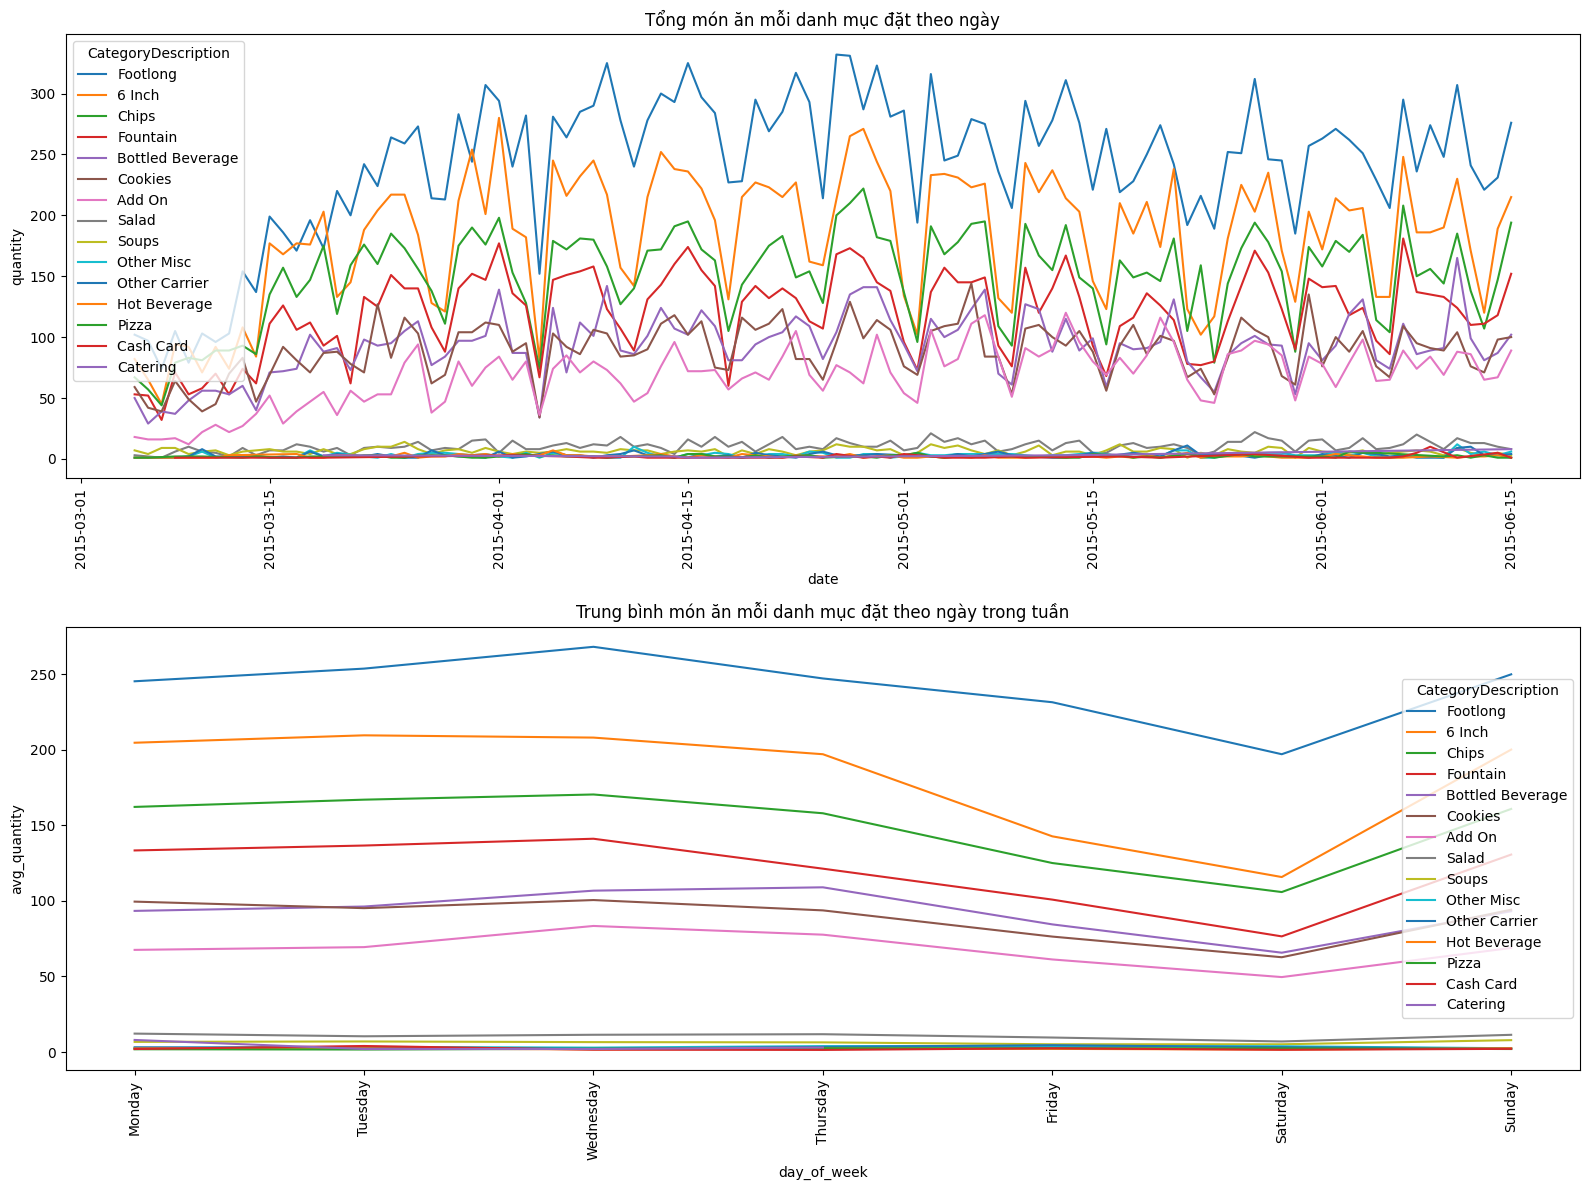

In [60]:
# Sắp xếp thứ tự hue theo tổng số lượng giảm dần
sorted_categories = groupby_day_CategoryDescription.groupby('CategoryDescription')['quantity'].sum().sort_values(ascending=False).index

# Sắp xếp các ngày trong tuần
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Cập nhật DataFrame để đảm bảo ngày trong tuần được sắp xếp đúng thứ tự
groupby_day_of_week_CategoryDescription['day_of_week'] = pd.Categorical(groupby_day_of_week_CategoryDescription['day_of_week'], categories=day_of_week_order, ordered=True)

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_CategoryDescription,
             x='date',
             y='quantity',
             palette='tab10',
             hue='CategoryDescription',
             hue_order=sorted_categories)
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn mỗi danh mục đặt theo ngày")

plt.subplot(2, 1, 2)
sns.lineplot(data=groupby_day_of_week_CategoryDescription,
             x='day_of_week',
             y='avg_quantity',
             hue='CategoryDescription',
             hue_order=sorted_categories,
             palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn mỗi danh mục đặt theo ngày trong tuần")

plt.tight_layout()
plt.show()

In [61]:
groupby_day_CategoryDescription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1323 non-null   datetime64[ns]
 1   day_of_week          1323 non-null   object        
 2   CategoryDescription  1323 non-null   object        
 3   price                1323 non-null   float64       
 4   quantity             1323 non-null   int64         
 5   revenue              1323 non-null   float64       
 6   Percentage           1323 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 72.5+ KB


Sắp xếp lại Hue, x, note thêm trục y

##### 2.2.5.1.2 Phần trăm doanh thu mỗi danh mục

In [62]:
# plt.figure(figsize=(16, 12))

# plt.subplot(2, 1, 1)
# sns.lineplot(data=groupby_day_CategoryDescription,
#              x='date',
#              y='Percentage',
#              palette='tab10',
#              hue='CategoryDescription')
# plt.xticks(rotation=90, ha='center')
# plt.title("Phần trăm doanh thu danh mục món ăn theo ngày")

# plt.subplot(2, 1, 2)
# sns.lineplot(data=groupby_day_of_week_CategoryDescription,
#              x='day_of_week',
#              y='Percentage',
#              hue='CategoryDescription',
#              palette='tab10')
# plt.xticks(rotation=90, ha='center')
# plt.title("Phần trăm doanh thu danh mục món ăn theo ngày trong tuần")


# plt.tight_layout()
# plt.show()

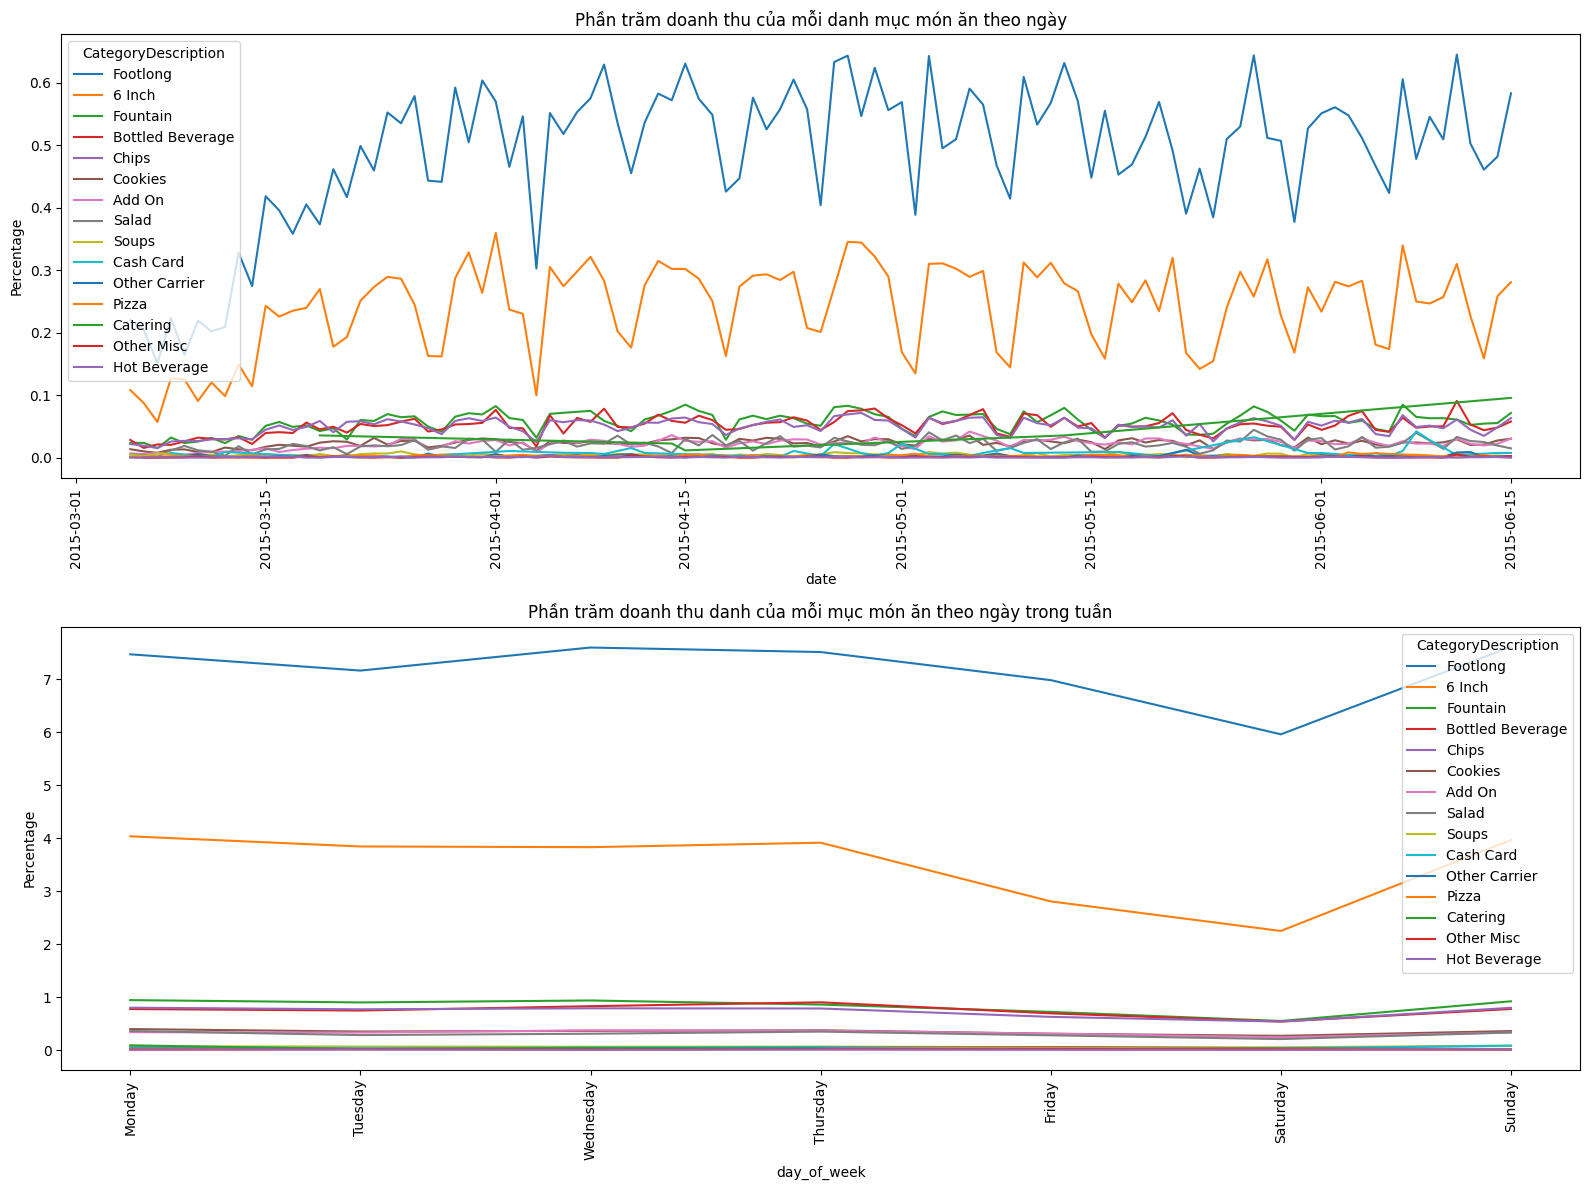

In [63]:
# Sắp xếp thứ tự hue theo tổng phần trăm doanh thu giảm dần
sorted_categories = groupby_day_CategoryDescription.groupby('CategoryDescription')['Percentage'].sum().sort_values(ascending=False).index

# Sắp xếp các ngày trong tuần
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Cập nhật DataFrame để đảm bảo ngày trong tuần được sắp xếp đúng thứ tự
groupby_day_of_week_CategoryDescription['day_of_week'] = pd.Categorical(groupby_day_of_week_CategoryDescription['day_of_week'], categories=day_of_week_order, ordered=True)

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_CategoryDescription,
             x='date',
             y='Percentage',
             palette='tab10',
             hue='CategoryDescription',
             hue_order=sorted_categories)
plt.xticks(rotation=90, ha='center')
plt.title("Phần trăm doanh thu của mỗi danh mục món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.lineplot(data=groupby_day_of_week_CategoryDescription,
             x='day_of_week',
             y='Percentage',
             hue='CategoryDescription',
             palette='tab10',
             hue_order=sorted_categories)
plt.xticks(rotation=90, ha='center')
plt.title("Phần trăm doanh thu danh của mỗi mục món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

In [64]:
groupby_day_of_week_CategoryDescription.groupby('CategoryDescription')['Percentage'].sum().sort_values(ascending=False)

CategoryDescription
Footlong           50.28
6 Inch             24.65
Fountain            5.86
Bottled Beverage    5.29
Chips               5.14
Cookies             2.46
Add On              2.33
Salad               2.16
Soups               0.50
Cash Card           0.39
Other Carrier       0.27
Pizza               0.23
Catering            0.20
Other Misc          0.13
Hot Beverage        0.09
Name: Percentage, dtype: float64

##### 2.2.5.1.4 Nhận xét

Nhận xét:
- *** Danh mục “Footlong”, "6 inch" có tỷ lệ đóng góp cao nhất vào doanh thu tổng thể. => So sánh theo từng cửa hàng? Có sự khác nhau hay không?
- Thứ Bảy có doanh thu cao mặc dù số lượng bán ra thấp hơn, có thể là do các món có giá trị cao

Nextstep: Xem xét các món ăn có doanh thu cao trong danh mục Footlong và 6 Inch để tối ưu hóa doanh thu.

#### 2.2.5.2 Kiểm tra món ăn có doanh thu cao trong Footlong & 6 inch

In [65]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [66]:
footlong_6inch = df_menuitem[(df_menuitem['CategoryDescription'] == 'Footlong') | (df_menuitem['CategoryDescription'] == '6 Inch')]
footlong_6inch.head()
print(footlong_6inch.shape)

(41991, 17)


In [67]:
footlong_6inch['Description'].nunique()

121

In [68]:
# Check data
print(footlong_6inch['SalesAmount'].sum() / df_menuitem['SalesAmount'].sum() * 100)

74.93488595401946


In [69]:
footlong_6inch.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [70]:

footlong_6inch_groupby_description = footlong_6inch.groupby(['Description']).agg(
  SalesAmount=('SalesAmount','sum')).reset_index().sort_values(by='SalesAmount', ascending=False)

footlong_6inch_groupby_description['RevenuePercentage'] = footlong_6inch_groupby_description['SalesAmount'] / footlong_6inch_groupby_description['SalesAmount'].sum() * 100
footlong_6inch_groupby_description['Cumsum'] = footlong_6inch_groupby_description['RevenuePercentage'].cumsum()
footlong_6inch_groupby_description
print(footlong_6inch_groupby_description.shape)

(121, 4)


In [71]:
# Bao nhiêu món ăn chiếm bao nhiêu % doanh thu456- memoryview1

print("Tổng số món ăn danh mục Footlong:", footlong_6inch['Description'].nunique())

footlong_description = footlong_6inch.groupby('Description')[['Quantity', 'SalesAmount']].sum().sort_values('SalesAmount', ascending=False).reset_index()
footlong_description['Percentage'] = footlong_description['SalesAmount'] / footlong_description['SalesAmount'].sum() * 100
footlong_description['Cumsum'] = footlong_description['Percentage'].cumsum()
footlong_description['ContributionGroup'] = pd.cut(footlong_description['Cumsum'], bins=[0, 25, 50, 75, 100], labels=['Top 25%', '25-50%', '50-75%', 'Bottom 25%'])
footlong_description

Tổng số món ăn danh mục Footlong: 121


Description  Quantity  SalesAmount  Percentage  Cumsum  \
0               Turkey FtLong      2594     17141.72        7.22    7.22   
1          Rst Chicken FtLong      2164     13906.59        5.86   13.08   
2                 Tuna FtLong      1962     13081.89        5.51   18.59   
3     Chicken Teriyaki FtLong      1837     12876.13        5.42   24.02   
4               Turkey 6 inch      2969     12269.72        5.17   29.18   
..                        ...       ...          ...         ...     ...   
116   Philly Chse Steak FtFbd         1         8.75        0.00   99.99   
117     Cold Cut Combo FlatBd         3         7.69        0.00  100.00   
118      ChipChMltGuac FlatBd         1         5.50        0.00  100.00   
119  Philly Chse Steak FlatBd         1         5.37        0.00  100.00   
120       Chicken Parm FlatBd        13         0.00        0.00  100.00   

    ContributionGroup  
0             Top 25%  
1             Top 25%  
2             Top 25%  
3             Top 25%  
4              25-50%  
..                ...  
116        Bottom 25%  
117        Bottom 25%  
118        Bottom 25%  
119               NaN  
120               NaN  

[121 rows x 6 columns]

In [72]:
# Các món ăn đóng góp khoảng 50% doanh thu
top_revenue = footlong_description[footlong_description['Cumsum'] <= 50]
top_revenue

Description  Quantity  SalesAmount  Percentage  Cumsum  \
0            Turkey FtLong      2594     17141.72        7.22    7.22   
1       Rst Chicken FtLong      2164     13906.59        5.86   13.08   
2              Tuna FtLong      1962     13081.89        5.51   18.59   
3  Chicken Teriyaki FtLong      1837     12876.13        5.42   24.02   
4            Turkey 6 inch      2969     12269.72        5.17   29.18   
5     Spicy Italian FtLong      1776      9868.56        4.16   33.34   
6            B.M.T. FtLong      1506      9832.03        4.14   37.48   
7          Meatball FtLong      1691      9235.59        3.89   41.37   
8              Tuna 6 inch      2214      8999.16        3.79   45.16   
9      Steak & Chse FtLong      1308      8884.93        3.74   48.91   

  ContributionGroup  
0           Top 25%  
1           Top 25%  
2           Top 25%  
3           Top 25%  
4            25-50%  
5            25-50%  
6            25-50%  
7            25-50%  
8            25-50%  
9            25-50%

In [73]:
footlong_description.describe()

Quantity  SalesAmount  Percentage  Cumsum
count    121.00       121.00      121.00  121.00
mean     360.53      1961.80        0.83   87.97
std      617.19      3457.34        1.46   20.84
min        1.00         0.00        0.00    7.22
25%       15.00        71.95        0.03   87.61
50%       43.00       235.85        0.10   97.82
75%      427.00      2072.41        0.87   99.62
max     2969.00     17141.72        7.22  100.00

In [74]:
top_revenue_list = top_revenue['Description'].to_list()
top_revenue_list

['Turkey FtLong',
 'Rst Chicken FtLong',
 'Tuna FtLong',
 'Chicken Teriyaki FtLong',
 'Turkey 6 inch',
 'Spicy Italian FtLong',
 'B.M.T. FtLong',
 'Meatball FtLong',
 'Tuna 6 inch',
 'Steak & Chse FtLong']

#### 2.2.5.3 Top 5 món ăn trong danh mục footlong & 6 inch
10 món ăn chiếm gần 50% doanh thu của doanh mục

In [75]:
footlong_6inch.shape

(41991, 17)

In [76]:
# Filter list revenue 
footlong_6inch_top_revenue_list = footlong_6inch[footlong_6inch['Description'].isin(top_revenue_list)]
print(footlong_6inch_top_revenue_list.shape)
print(footlong_6inch_top_revenue_list['Description'].unique())

(19093, 17)
['Turkey 6 inch' 'Spicy Italian FtLong' 'Turkey FtLong'
 'Chicken Teriyaki FtLong' 'Steak & Chse FtLong' 'Tuna FtLong'
 'Tuna 6 inch' 'B.M.T. FtLong' 'Rst Chicken FtLong' 'Meatball FtLong']


In [77]:
footlong_6inch_top_revenue_list.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [78]:
# Group by day top description item
footlong_6inch_top_revenue_list_groupby_day = footlong_6inch_top_revenue_list.groupby(['date', 'day_of_week', 'Description', 'StoreNumber']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index().sort_values('SalesAmount', ascending=False)

footlong_6inch_top_revenue_list_groupby_day

date day_of_week              Description  StoreNumber  Quantity  \
2519 2015-05-16    Saturday            Turkey FtLong         4904        84   
417  2015-03-21    Saturday            Turkey FtLong         4904        24   
1655 2015-04-23    Thursday            Turkey FtLong         4904        23   
2899 2015-05-27   Wednesday  Chicken Teriyaki FtLong        12631        18   
3468 2015-06-11    Thursday  Chicken Teriyaki FtLong        12631        17   
...         ...         ...                      ...          ...       ...   
3372 2015-06-08      Monday              Tuna 6 inch        12631         1   
2143 2015-05-06   Wednesday            Turkey 6 inch        12631         1   
2733 2015-05-22      Friday              Tuna 6 inch        12631         1   
1607 2015-04-22   Wednesday              Tuna 6 inch        20974         1   
9    2015-03-05    Thursday      Steak & Chse FtLong        12631         1   

      SalesAmount  
2519       565.58  
417        161.80  
1655       154.63  
2899       129.81  
3468       122.74  
...           ...  
3372         3.67  
2143         3.67  
2733         3.67  
1607         3.65  
9            0.00  

[3652 rows x 6 columns]

In [79]:
# Group by day top description item
footlong_6inch_top_revenue_list_groupby_day_of_week = footlong_6inch_top_revenue_list_groupby_day.groupby(['day_of_week', 'Description', 'StoreNumber']).agg(
  Quantity=('Quantity', 'mean'),
  SalesAmount=('SalesAmount', 'mean')
).reset_index().sort_values('SalesAmount', ascending=False)

footlong_6inch_top_revenue_list_groupby_day_of_week

day_of_week              Description  StoreNumber  Quantity  SalesAmount
116    Saturday            Turkey FtLong         4904     13.14        87.98
13       Friday       Rst Chicken FtLong        12631     12.33        76.74
196    Thursday            Turkey FtLong         4904     11.38        76.18
276   Wednesday            Turkey FtLong         4904     10.31        68.71
165    Thursday  Chicken Teriyaki FtLong        12631     10.07        67.08
..          ...                      ...          ...       ...          ...
107    Saturday              Tuna 6 inch        46673      2.33        10.24
26       Friday              Tuna 6 inch        20974      2.18         9.13
91     Saturday          Meatball FtLong        46673      1.33         8.87
11       Friday          Meatball FtLong        46673      1.14         7.71
106    Saturday              Tuna 6 inch        20974      1.50         6.38

[280 rows x 5 columns]

/var/folders/dq/v_fjhwnn1d51xqk1b5hc753c0000gn/T/ipykernel_1092/2270572503.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=footlong_6inch_top_revenue_list_groupby_day,
/var/folders/dq/v_fjhwnn1d51xqk1b5hc753c0000gn/T/ipykernel_1092/2270572503.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=footlong_6inch_top_revenue_list_groupby_day_of_week,


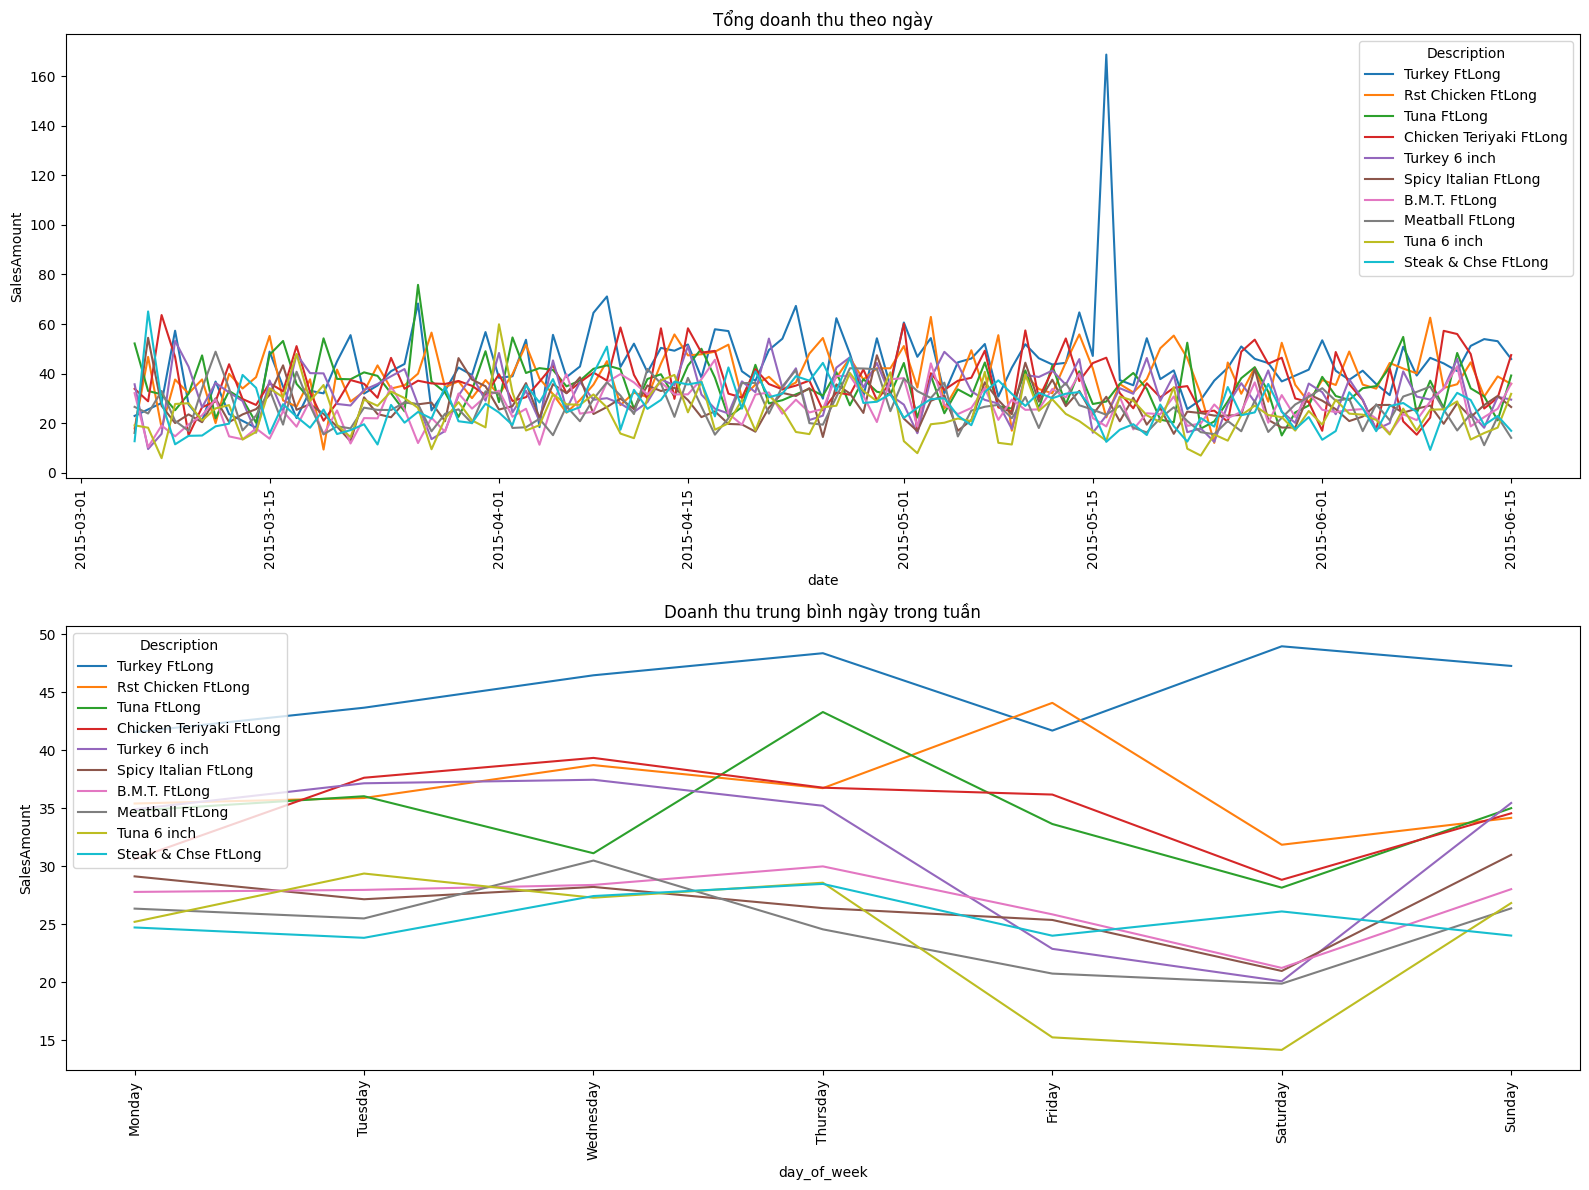

In [80]:
# Tính tổng doanh thu cho mỗi Description
total_sales_per_description = footlong_6inch_top_revenue_list_groupby_day.groupby('Description')['SalesAmount'].sum().reset_index()

# Sắp xếp Description theo tổng doanh thu giảm dần
total_sales_per_description = total_sales_per_description.sort_values(by='SalesAmount', ascending=False)
desired_order = total_sales_per_description['Description'].tolist()

# Tạo biến Categorical cho Description theo thứ tự đã sắp xếp
footlong_6inch_top_revenue_list_groupby_day['Description'] = pd.Categorical(footlong_6inch_top_revenue_list_groupby_day['Description'], categories=desired_order, ordered=True)
footlong_6inch_top_revenue_list_groupby_day_of_week['Description'] = pd.Categorical(footlong_6inch_top_revenue_list_groupby_day_of_week['Description'], categories=desired_order, ordered=True)

# Sắp xếp ngày trong tuần theo thứ tự mong muốn
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
footlong_6inch_top_revenue_list_groupby_day_of_week['day_of_week'] = pd.Categorical(footlong_6inch_top_revenue_list_groupby_day_of_week['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=footlong_6inch_top_revenue_list_groupby_day,
             x='date',
             y='SalesAmount',
             hue='Description',
             legend='full',
             ci=None)  # Vô hiệu hóa khoảng màu
plt.xticks(rotation=90, ha='center')
plt.title("Tổng doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.lineplot(data=footlong_6inch_top_revenue_list_groupby_day_of_week,
             x='day_of_week',
             y='SalesAmount',
             hue='Description',
             legend='full',
             ci=None)  # Vô hiệu hóa khoảng màu
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình ngày trong tuần")

plt.tight_layout()
plt.show()

Nhận xét:
- Turkey FtLong đem lại doanh thu cao

### 2.2.6 Phân tích món ăn - note

In [81]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [82]:
# df_menuitem.groupby(['date', 'day_of_week','Description', 'StoreNumber']).agg(
  
# )

# 3. So sánh doanh thu từng cửa hàng
So sánh doanh thu của từng cửa hàng để xác định cửa hàng có doanh thu cao nhất và thấp nhất

## 3.1 Tổng

In [83]:
df_menuitem.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum'))

revenue
StoreNumber          
4904        104642.35
12631        87380.05
20974        66829.26
46673        57927.15

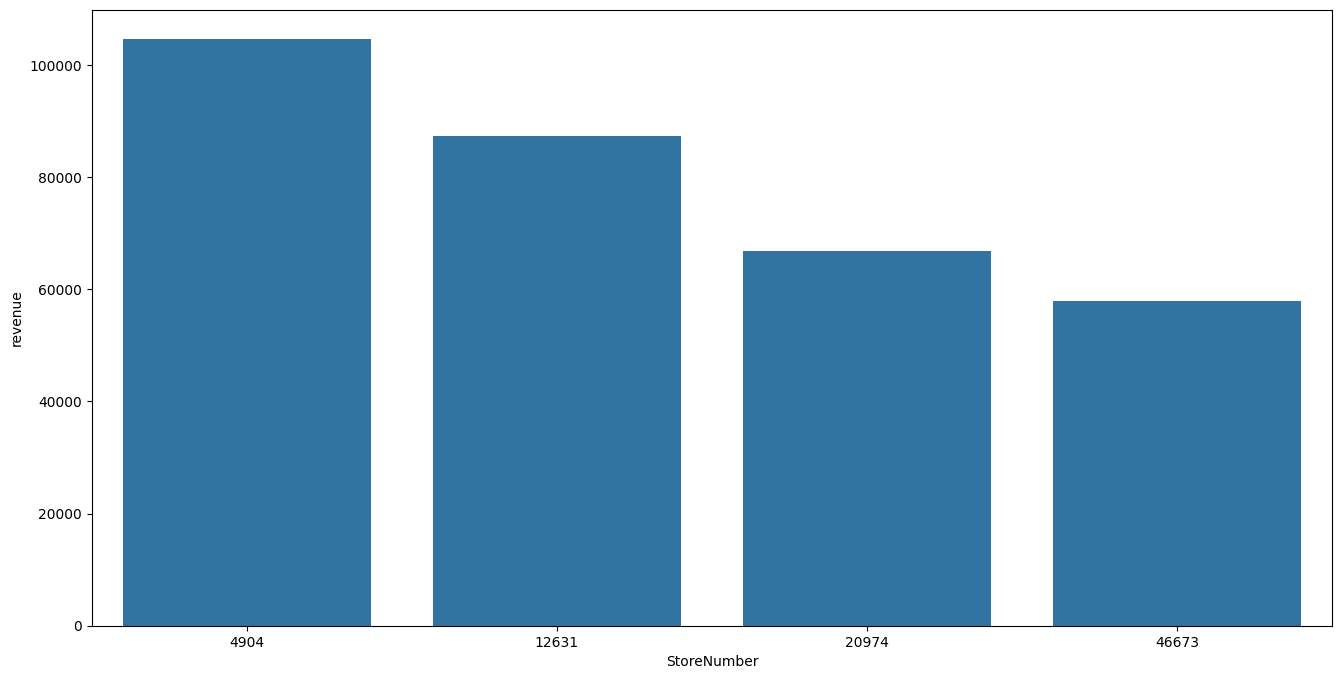

In [84]:
plt.figure(figsize=(16, 8))

sns.barplot(data=df_menuitem.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

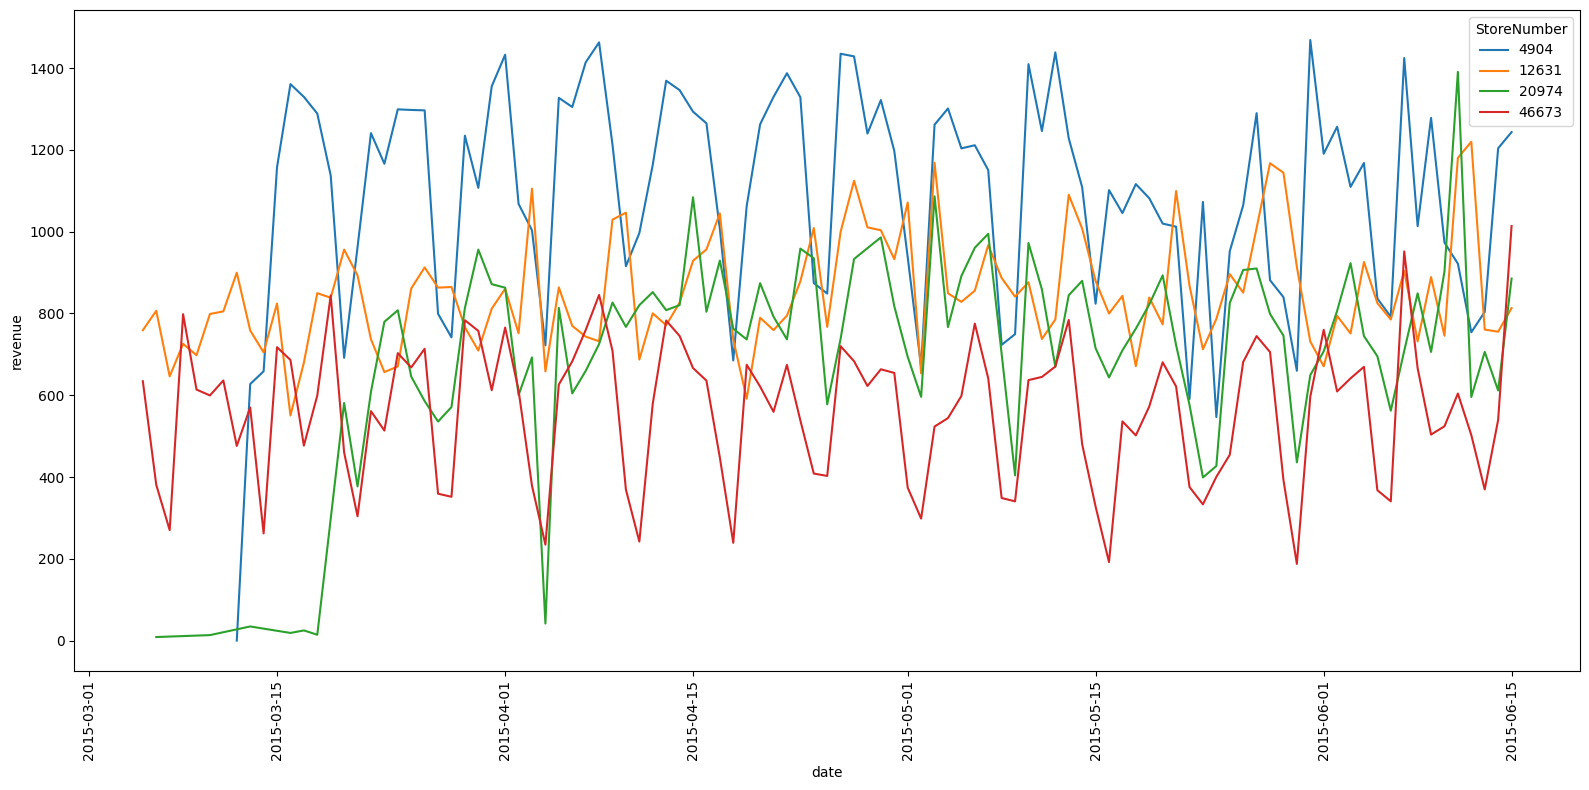

In [85]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=df_menuitem.groupby(['date', 'StoreNumber']).agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='date',
            y='revenue',
            hue='StoreNumber',
            palette='tab10')

plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

## 3.2 Non-outliers

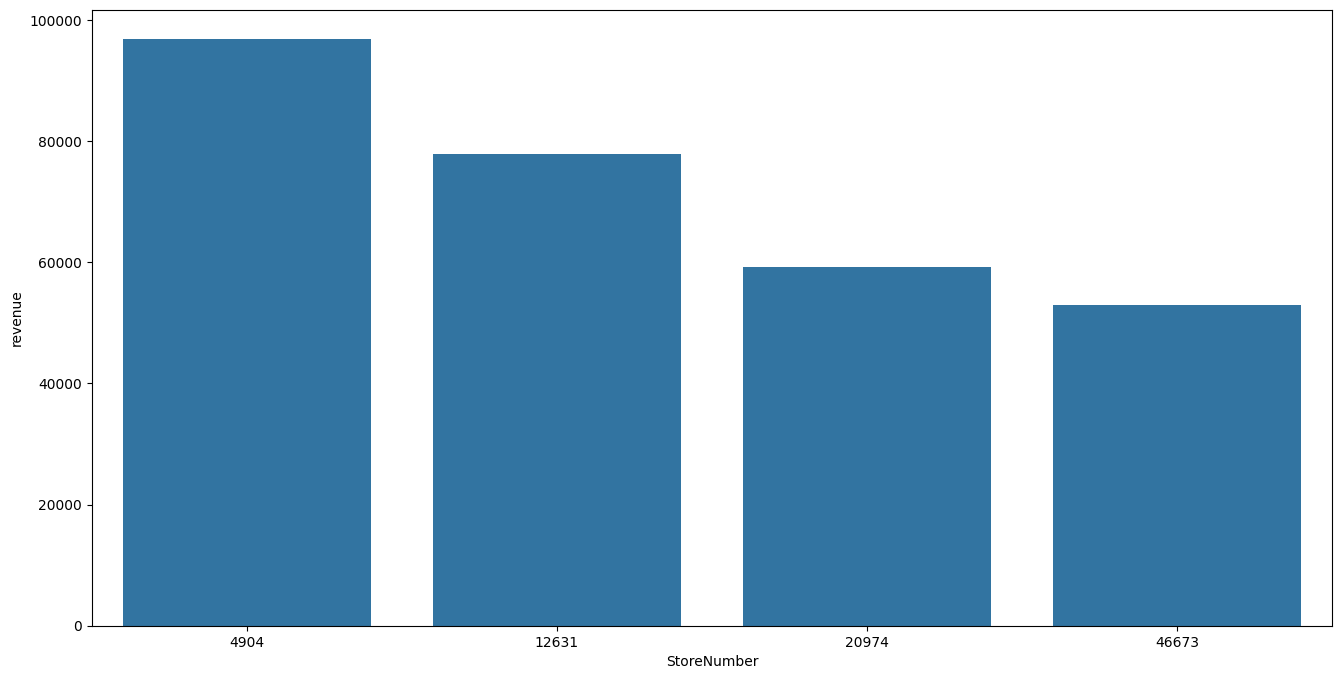

In [86]:
plt.figure(figsize=(16, 8))

sns.barplot(data=non_outliers_quantity.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

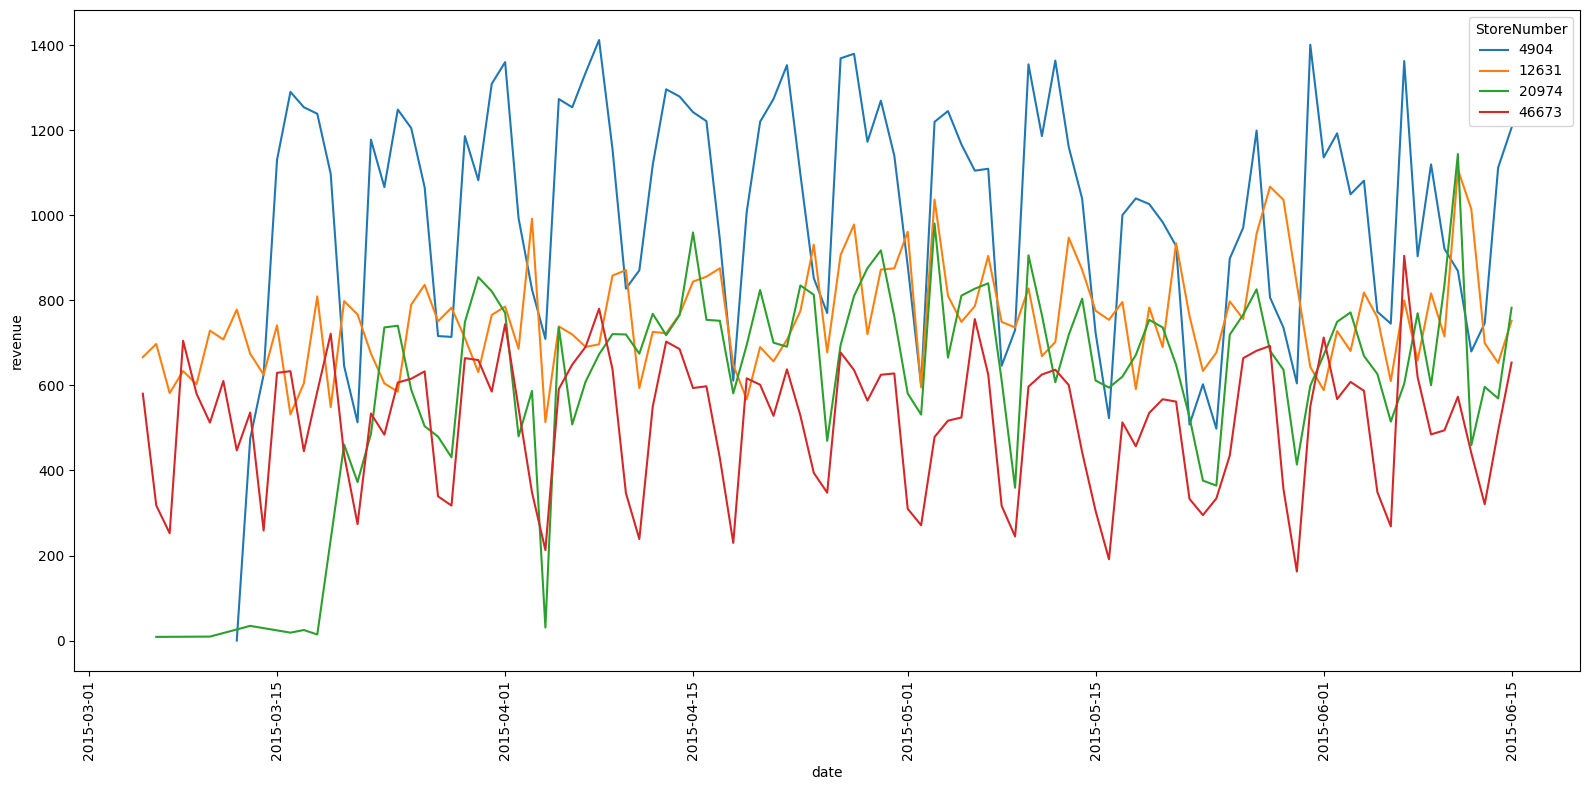

In [87]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=non_outliers_quantity.groupby(['date', 'StoreNumber']).agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='date',
            y='revenue',
            hue='StoreNumber',
            palette='tab10')

plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

# 4. Phân tích tác động của giảm giá
Phân tích tác động của việc giảm giá lên số lượng bán ra và doanh thu.

## 4.1 Merge ordersale và menuitem
Mục tiêu: kiểm tra đơn hàng giảm giá. Các yếu tố thời gian liên quan tới chương trình giảm giá như thời gian trước và sau áp dụng giảm giá

In [88]:
merged_ordersale_menuitem = pd.merge(df_ordersale, df_menuitem, on="MD5KEY_ORDERSALE", how="inner")

In [89]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [90]:
print(merged_ordersale_menuitem['MD5KEY_ORDERSALE'].nunique())
print(merged_ordersale_menuitem['SalesAmount'].sum())

40621
316778.81


## 4.2 Kiểm tra doanh thu có giảm giá và không giảm giá

### 4.2.1 Kiểm tra tác động theo ngày

In [91]:
print(merged_ordersale_menuitem[merged_ordersale_menuitem['DiscountAmount'] == 0]['SalesAmount'].sum())
print(merged_ordersale_menuitem[merged_ordersale_menuitem['DiscountAmount'] > 0]['SalesAmount'].sum())

213484.28
103294.52999999998


In [92]:
merged_groupby_day = merged_ordersale_menuitem.groupby('date_x').agg(
  total_discount=('DiscountAmount', 'sum'),
  total_salesamount=('SalesAmount', 'sum')).reset_index()

merged_groupby_day

date_x  total_discount  total_salesamount
0   2015-03-05           76.06            1393.34
1   2015-03-06           54.82            1196.23
2   2015-03-07           37.69             916.41
3   2015-03-08           84.10            1524.00
4   2015-03-09           77.35            1311.75
..         ...             ...                ...
98  2015-06-11          155.51            4097.40
99  2015-06-12          157.24            3072.31
100 2015-06-13          107.73            2640.17
101 2015-06-14          124.58            3110.87
102 2015-06-15          192.71            3955.69

[103 rows x 3 columns]

In [93]:
print(merged_groupby_day[merged_groupby_day['total_discount'] == 0]['total_salesamount'].sum())
print(merged_groupby_day[merged_groupby_day['total_discount'] > 0]['total_salesamount'].sum())

0.0
316778.81000000006


Nhận xét: tất cả các ngày đều có giảm giá

### 4.2.2 Kiểm tra theo số lượng trung bình item mỗi order

In [94]:
merged_groupby_order = merged_ordersale_menuitem.groupby('MD5KEY_ORDERSALE').agg(
  total_items=('MD5KEY_MENUITEM', 'count'),
  total_quantity=('Quantity', 'sum'),
  total_discount=('DiscountAmount', 'sum'),
  total_salesamount=('SalesAmount', 'sum')
).reset_index()

merged_groupby_order

MD5KEY_ORDERSALE  total_items  total_quantity  \
0      00040FB2079EE37A1A3347134FDA1222            1               1   
1      000487D84122ECFC7C2B0681D7847D07            2               4   
2      0006541E961609F6EA9B93AF996791FA            1               1   
3      0007198A6EA115A618FB1F7A47DA5A94            1               1   
4      0009AF6BC70525EA7865AB795C651219            2               2   
...                                 ...          ...             ...   
40616  FFF4B340CBD214BD2A0C12944DD6FC4C            1               1   
40617  FFF4B38DC800DE5784EC2F27909AB4B9            3               3   
40618  FFF9C0AFD57C0B07E3ADE021C41BC222            1               1   
40619  FFFB7296078113301047E98795ED0836            3               3   
40620  FFFC4FB2B89C83C2ECF5C05A098CA189            1               1   

       total_discount  total_salesamount  
0                0.75               6.00  
1                1.50              14.20  
2                0.00               4.25  
3                0.75               6.00  
4                7.30               0.00  
...               ...                ...  
40616            0.00               5.50  
40617            0.00               9.25  
40618            0.00               6.75  
40619            1.55               6.00  
40620            0.00               5.00  

[40621 rows x 5 columns]

In [95]:
print("Doanh thu không giảm giá:", merged_groupby_order[merged_groupby_order['total_discount'] == 0]['total_salesamount'].sum())
print("Doanh thu có giảm giá", merged_groupby_order[merged_groupby_order['total_discount'] > 0]['total_salesamount'].sum())
print("Số lượng món trong mỗi order không giảm giá:", merged_groupby_order[merged_groupby_order['total_discount'] == 0]['total_items'].sum())
print("Số lượng món trong mỗi order có giảm giá:",merged_groupby_order[merged_groupby_order['total_discount'] > 0]['total_items'].sum())

Doanh thu không giảm giá: 189332.31
Doanh thu có giảm giá 127446.5
Số lượng món trong mỗi order không giảm giá: 44791
Số lượng món trong mỗi order có giảm giá: 46629


### 4.3 Đơn hàng có giảm giá và không giảm giá

In [96]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [97]:
# Groupby order
order_group = merged_ordersale_menuitem.groupby('MD5KEY_ORDERSALE').agg(
  Discounted=("DiscountAmount", "sum"),
  TotalSaleAmount=('SalesAmount', 'sum')).reset_index()

print("Order discount:", order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].count())
print("Order non discount:", order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].count())
print(order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].count() + order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].count())

print("Doanh thu:", merged_ordersale_menuitem['SalesAmount'].sum())
print("Doanh thu:", df_menuitem['SalesAmount'].sum())

print(merged_ordersale_menuitem['MD5KEY_ORDERSALE'].nunique())
print(order_group['MD5KEY_ORDERSALE'].nunique())
print(order_group['TotalSaleAmount'].sum())

order_group

Order discount: 13837
Order non discount: 26784
40621
Doanh thu: 316778.81
Doanh thu: 316778.81
40621
40621
316778.81000000006


MD5KEY_ORDERSALE  Discounted  TotalSaleAmount
0      00040FB2079EE37A1A3347134FDA1222        0.75             6.00
1      000487D84122ECFC7C2B0681D7847D07        1.50            14.20
2      0006541E961609F6EA9B93AF996791FA        0.00             4.25
3      0007198A6EA115A618FB1F7A47DA5A94        0.75             6.00
4      0009AF6BC70525EA7865AB795C651219        7.30             0.00
...                                 ...         ...              ...
40616  FFF4B340CBD214BD2A0C12944DD6FC4C        0.00             5.50
40617  FFF4B38DC800DE5784EC2F27909AB4B9        0.00             9.25
40618  FFF9C0AFD57C0B07E3ADE021C41BC222        0.00             6.75
40619  FFFB7296078113301047E98795ED0836        1.55             6.00
40620  FFFC4FB2B89C83C2ECF5C05A098CA189        0.00             5.00

[40621 rows x 3 columns]

#### 4.3.1 Lọc đơn hàng có giảm giá và không giảm giá

In [98]:
# Get index of order discount and non discount
discount_list = order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].tolist()
non_discount_list = order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].tolist()

# Filter discount and non discount by index
discount_order = merged_ordersale_menuitem[merged_ordersale_menuitem['MD5KEY_ORDERSALE'].isin(discount_list)]
non_discount_order = merged_ordersale_menuitem[merged_ordersale_menuitem['MD5KEY_ORDERSALE'].isin(non_discount_list)]

print("Số đơn hàng discount:", discount_order['MD5KEY_ORDERSALE'].nunique())
print("Số đơn hàng không discount:", non_discount_order['MD5KEY_ORDERSALE'].nunique())
print("Tổng đơn hàng:", discount_order['MD5KEY_ORDERSALE'].nunique() + non_discount_order['MD5KEY_ORDERSALE'].nunique())

print("Doanh thu discount:", discount_order['SalesAmount'].sum())
print("Doanh thu non discount:", non_discount_order['SalesAmount'].sum())
print("Tổng doanh thu:", discount_order['SalesAmount'].sum() + non_discount_order['SalesAmount'].sum())
print(order_group['TotalSaleAmount'].sum())


Số đơn hàng discount: 13837
Số đơn hàng không discount: 26784
Tổng đơn hàng: 40621
Doanh thu discount: 127446.5
Doanh thu non discount: 189332.31
Tổng doanh thu: 316778.81
316778.81000000006


#### 4.3.2 Đơn hàng có giảm giá

##### 4.3.2.1 Đếm số lượng món giảm giá

In [99]:

# Count the number of discounted items in each order
count_item_discount = discount_order[discount_order['DiscountAmount'] > 0]
order_discount_summary_item = count_item_discount.groupby('MD5KEY_ORDERSALE').agg(quantity_item_discount=('DiscountAmount', 'count')).reset_index()
order_discount_summary_item.head()

MD5KEY_ORDERSALE  quantity_item_discount
0  00040FB2079EE37A1A3347134FDA1222                       1
1  000487D84122ECFC7C2B0681D7847D07                       1
2  0007198A6EA115A618FB1F7A47DA5A94                       1
3  0009AF6BC70525EA7865AB795C651219                       2
4  000F687919E50697C501391931A4A885                       3

##### 4.3.2.2 Group đơn hàng

In [100]:
#Group by order
discount_order_group_1 = discount_order.groupby(['MD5KEY_ORDERSALE', 'StoreNumber_x', 'date_x', 'day_of_week'], observed=True).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum'),
  DiscountAmount=('DiscountAmount', 'sum'),
  TaxAmount=('TaxAmount_y', 'sum'),
  MealLocation=('MealLocation', 'sum')
).reset_index()

In [101]:
discount_order_group_1['MealLocation'] = discount_order_group_1['MealLocation'].apply(lambda x: 1 if x > 0 else 0)
discount_order_group_1['MealLocation'].unique()

array([0, 1])

##### 4.3.2.3 Merge đơn hàng và số lượng món giảm giá

In [102]:
# Merge discount_order_groupby
merged_discount_order_groupby = pd.merge(discount_order_group_1, order_discount_summary_item, on='MD5KEY_ORDERSALE', how='left')
merged_discount_order_groupby.head()

MD5KEY_ORDERSALE  StoreNumber_x     date_x day_of_week  \
0  00040FB2079EE37A1A3347134FDA1222          12631 2015-04-03      Friday   
1  000487D84122ECFC7C2B0681D7847D07          12631 2015-04-03      Friday   
2  0007198A6EA115A618FB1F7A47DA5A94          12631 2015-04-16    Thursday   
3  0009AF6BC70525EA7865AB795C651219          12631 2015-04-22   Wednesday   
4  000F687919E50697C501391931A4A885          12631 2015-06-03   Wednesday   

   Quantity  SalesAmount  DiscountAmount  TaxAmount  MealLocation  \
0         1         6.00            0.75       0.53             0   
1         4        14.20            1.50       1.26             0   
2         1         6.00            0.75       0.53             0   
3         2         0.00            7.30       0.00             0   
4         3         6.75            0.40       0.60             0   

   quantity_item_discount  
0                       1  
1                       1  
2                       1  
3                       2  
4                       3

In [103]:
# Kiểm tra số lương món kiểm giá có bị tính sai không
merged_discount_order_groupby['check_quantity_item_discount'] = merged_discount_order_groupby['Quantity'] - merged_discount_order_groupby['quantity_item_discount']
print(merged_discount_order_groupby['check_quantity_item_discount'].unique())

[  0   3   1   2   5   4   6   9   8   7  13  14  10  37  12  79 109  75
  15  16  72]


In [104]:
# Số đơn hàng ăn tại chỗ và đơn hàng mang đi
mealLocation_group = merged_discount_order_groupby.groupby('MealLocation').agg(
  total_order=('MealLocation', 'count'),
  total_revenue=('SalesAmount', 'sum')).reset_index()
mealLocation_group

MealLocation  total_order  total_revenue
0             0        11727      110240.60
1             1         2110       17205.90

In [105]:
mealLocation_group['Percentage_order'] = mealLocation_group['total_order'] / merged_discount_order_groupby.shape[0] * 100
mealLocation_group['Percentage_revenue'] = mealLocation_group['total_revenue'] / merged_discount_order_groupby['SalesAmount'].sum() * 100
mealLocation_group['MealLocation_text'] = mealLocation_group['MealLocation'].apply(lambda x: 'Ăn tại chỗ' if x==0 else 'Mang đi')
mealLocation_group

MealLocation  total_order  total_revenue  Percentage_order  \
0             0        11727      110240.60             84.75   
1             1         2110       17205.90             15.25   

   Percentage_revenue MealLocation_text  
0               86.50        Ăn tại chỗ  
1               13.50           Mang đi

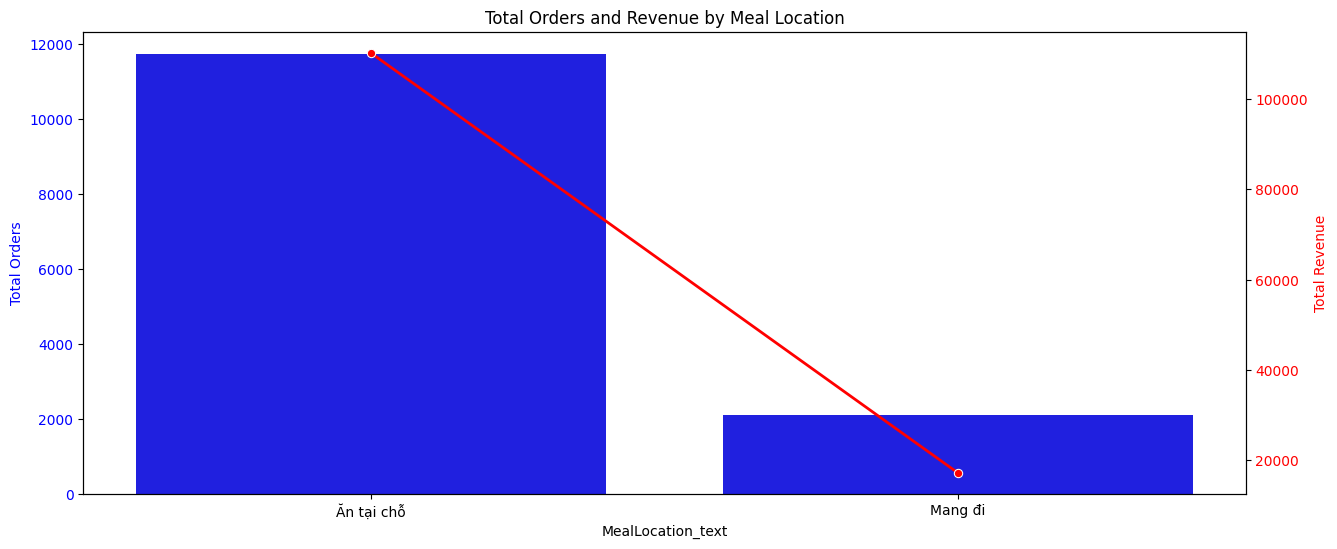

In [106]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Vẽ biểu đồ thanh cho total_order
sns.barplot(data=mealLocation_group, x='MealLocation_text', y='total_order', ax=ax1, color='b')
ax1.set_ylabel('Total Orders', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Tạo trục y thứ hai để vẽ biểu đồ đường cho total_revenue
ax2 = ax1.twinx()
sns.lineplot(data=mealLocation_group, x='MealLocation_text', y='total_revenue', ax=ax2, color='r', marker='o', linewidth=2)
ax2.set_ylabel('Total Revenue', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Thiết lập tiêu đề và hiển thị biểu đồ
plt.title('Total Orders and Revenue by Meal Location')
plt.show()

##### 4.3.2.4 Phân tích cơ bản

In [107]:
merged_discount_order_groupby.select_dtypes(include="number").describe()

StoreNumber_x  Quantity  SalesAmount  DiscountAmount  TaxAmount  \
count       13837.00  13837.00     13837.00        13837.00   13837.00   
mean        19135.03      3.64         9.21            1.33       0.72   
std         15297.77      2.31         7.71            1.60       0.69   
min          4904.00      1.00         0.00            0.05       0.00   
25%          4904.00      3.00         6.00            0.30       0.53   
50%         12631.00      3.00         7.90            0.75       0.66   
75%         20974.00      4.00        10.65            1.70       0.91   
max         46673.00    112.00       508.58           38.50      43.23   

       MealLocation  quantity_item_discount  check_quantity_item_discount  
count      13837.00                13837.00                      13837.00  
mean           0.15                    2.76                          0.88  
std            0.36                    1.13                          1.97  
min            0.00                    1.00                          0.00  
25%            0.00                    3.00                          0.00  
50%            0.00                    3.00                          0.00  
75%            0.00                    3.00                          1.00  
max            1.00                   24.00                        109.00

##### 4.3.2.5 Tính các chỉ số trung bình mỗi đơn hàng
- Doanh thu
- Số lượng món
- Số lượng món giảm giá

In [108]:
print("Tổng doanh thu:", merged_discount_order_groupby['SalesAmount'].sum())
print("Doanh thu trung bình mỗi đơn hàng:", merged_discount_order_groupby['SalesAmount'].mean())
print("Trung bình giảm giá mỗi đơn hàng:", merged_discount_order_groupby['DiscountAmount'].mean())
print("Trung bình số lượng món mỗi đơn hàng:", merged_discount_order_groupby['Quantity'].mean())
print("Trung bình số lượng món giảm giá mỗi đơn hàng:", merged_discount_order_groupby['quantity_item_discount'].mean())


Tổng doanh thu: 127446.5
Doanh thu trung bình mỗi đơn hàng: 9.210558647105586
Trung bình giảm giá mỗi đơn hàng: 1.3266611259666112
Trung bình số lượng món mỗi đơn hàng: 3.6380718363807185
Trung bình số lượng món giảm giá mỗi đơn hàng: 2.759124087591241


##### 4.3.2.6 Visualization

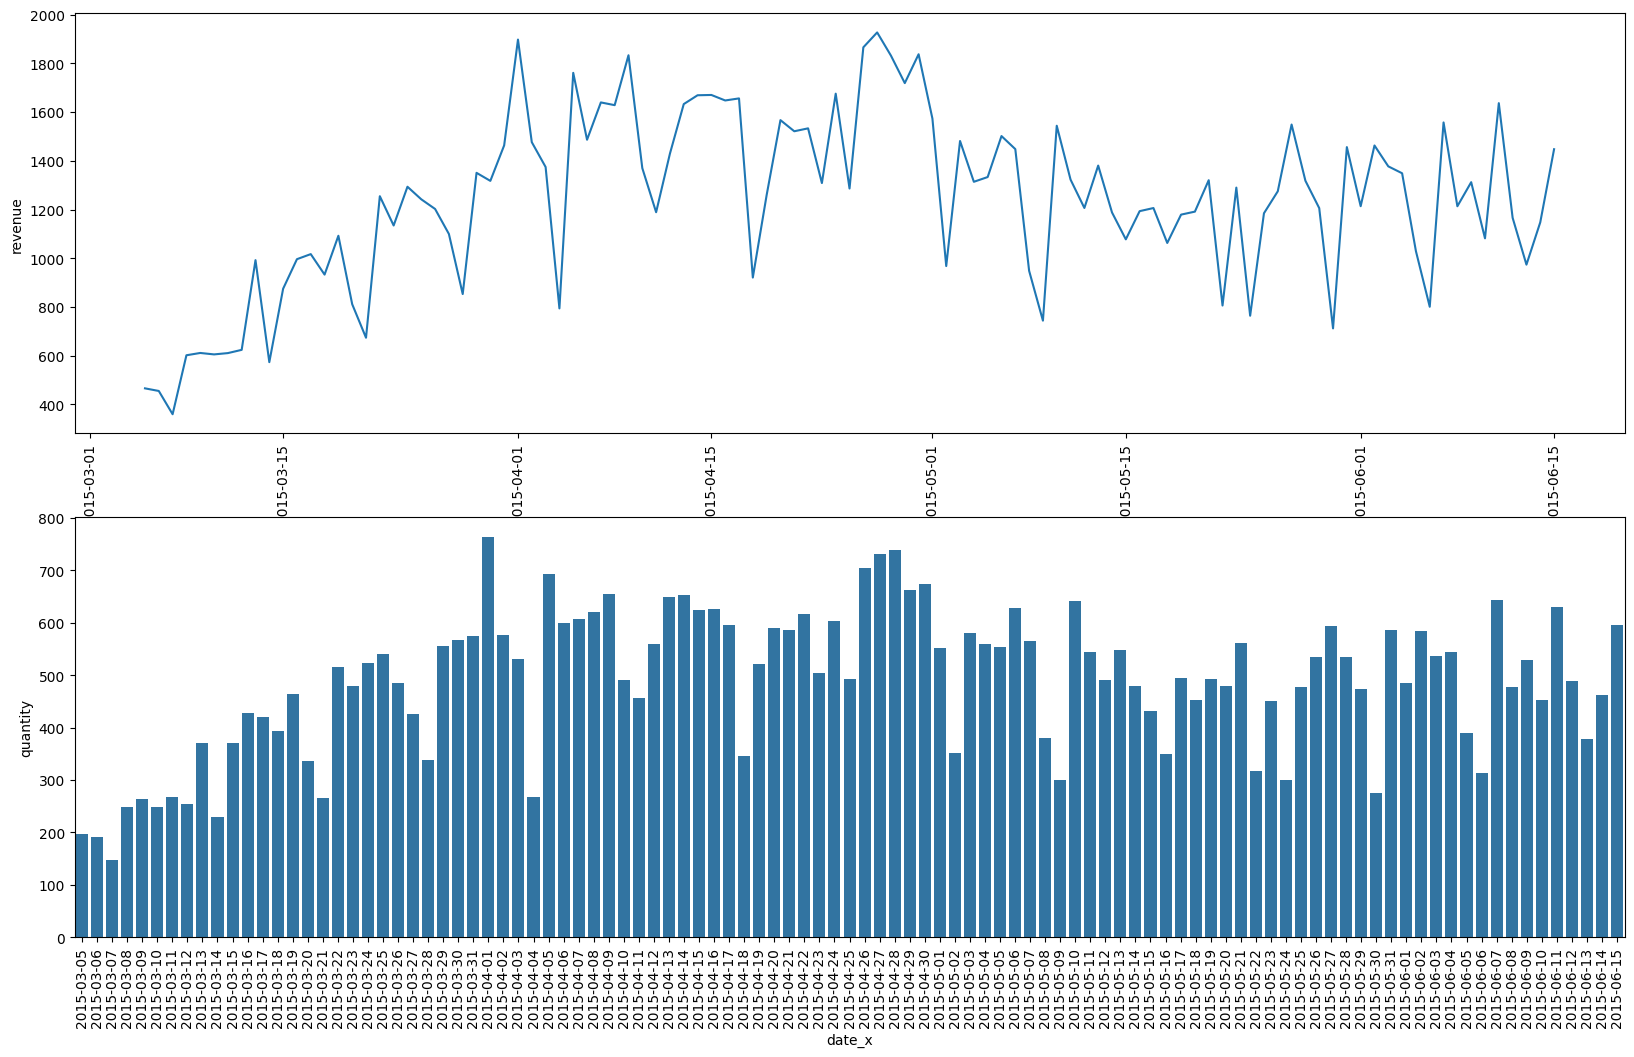

In [109]:
plt.figure(figsize=(20, 12))

plt.subplot(2,1,1)
sns.lineplot(data=merged_discount_order_groupby.groupby('date_x').agg(revenue=('SalesAmount', 'sum')),
             x='date_x',
             y='revenue',)
plt.xticks(rotation=90, ha='center')

plt.subplot(2,1,2)
sns.barplot(data=merged_discount_order_groupby.groupby('date_x').agg(quantity=('Quantity', 'sum')),
             x='date_x',
             y='quantity')
plt.xticks(rotation=90, ha='center')

plt.tight_layout
plt.show()

In [110]:
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-15"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-15"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-16"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-16"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-17"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-17"]['SalesAmount'].sum())
print()

print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-22"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-22"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-23"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-23"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-24"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-24"]['SalesAmount'].sum())

431 1077.75
350 1193.4899999999998
495 1206.25

318 806.08
451 1290.13
301 764.2299999999999


##### 4.3.2.7 kiểm tra món ăn 2 ngày 16 - 23

In [111]:
discount_order[(discount_order['date_x'] == "2015-05-16")]

MD5KEY_ORDERSALE  ChangeReceived  OrderNumber  \
63493  0368302B1357712075FB833657E61D1C            0.25        11495   
63506  0BD295387D4D4A253C7C2EDC32921493            0.00         8717   
63507  0BD295387D4D4A253C7C2EDC32921493            0.00         8717   
63508  0BD295387D4D4A253C7C2EDC32921493            0.00         8717   
63519  0FF6A54C2B033BD764FB5FC54397AC16            0.00         8697   
...                                 ...             ...          ...   
64099  F04AFC3FEFCC7865D47F665371F55BE5            0.00         5500   
64106  F7CBAD56B76AA942F525CEE4EA97FF06            0.00         8681   
64107  F843D481B38429B124F8A91C15DB1CD1            0.00         5173   
64108  F843D481B38429B124F8A91C15DB1CD1            0.00         5173   
64109  F843D481B38429B124F8A91C15DB1CD1            0.00         5173   

       TaxAmount_x  MealLocation  TransactionId  StoreNumber_x     date_x  \
63493         0.00             1          11495           4904 2015-05-16   
63506         0.87             0           8718          12631 2015-05-16   
63507         0.87             0           8718          12631 2015-05-16   
63508         0.87             0           8718          12631 2015-05-16   
63519         0.83             0           8698          12631 2015-05-16   
...            ...           ...            ...            ...        ...   
64099         0.59             0           5500          20974 2015-05-16   
64106         0.29             0           8682          12631 2015-05-16   
64107         0.95             0           5173          46673 2015-05-16   
64108         0.95             0           5173          46673 2015-05-16   
64109         0.95             0           5173          46673 2015-05-16   

                        MD5KEY_MENUITEM CategoryDescription  ...  \
63493  CEB9C4A6C4C8CC5B1B31467ECAD34C1B            Footlong  ...   
63506  3E03123AB392BAC39A9CE34BB27BA1A2            Fountain  ...   
63507  54F3D37FB2BBDBDFF6D394405893A5F1            Footlong  ...   
63508  558716098216858B069B9DEC01B85216               Chips  ...   
63519  4010FC07C2DBD92BEBF48ADC0A984386    Bottled Beverage  ...   
...                                 ...                 ...  ...   
64099  F4D75B56F82E2DE6FE93954A6ABA0D9D              6 Inch  ...   
64106  E15FC30219173D73DB7D4E6807901A96              6 Inch  ...   
64107  9860A94A9E2B1CC1EFD352C3DAC6E33E               Chips  ...   
64108  D5FAD1D77E3FCB881B5B2716CA79A3BC            Footlong  ...   
64109  FADB59BD3FBDAC071F60CE75122EDFF0    Bottled Beverage  ...   

      AdjustedPrice DiscountAmount  Price  Quantity        PLU    Id  \
63493          5.75           1.00   6.75         1  111000006    74   
63506          1.57           0.03   1.60         1  212000126   280   
63507          7.10           0.15   7.25         1  111000021    38   
63508          1.08           0.02   1.10         1  311000100   277   
63519          1.73           0.07   1.80         1  221000133   279   
...             ...            ...    ...       ...        ...   ...   
64099          4.31           0.19   4.50         1  121000731  7040   
64106          3.19           0.56   3.75         1  121000003    59   
64107          1.06           0.04   1.10         1  311000100   277   
64108          7.47           0.28   7.75         1  111000006    74   
64109          2.02           0.08   2.10         1  221000133   279   

          date_y  SalesAmount  day_of_week  DiscountPercentage  
63493 2015-05-16         5.75     Saturday               14.81  
63506 2015-05-16         1.57     Saturday                1.88  
63507 2015-05-16         7.10     Saturday                2.07  
63508 2015-05-16         1.08     Saturday                1.82  
63519 2015-05-16         1.73     Saturday                3.89  
...          ...          ...          ...                 ...  
64099 2015-05-16         4.31     Saturday                4.22  
64106 2015-05-16         3.19  

In [112]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['MD5KEY_ORDERSALE']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index().sort_values(by='SalesAmount', ascending=False)

MD5KEY_ORDERSALE  Quantity  SalesAmount
59  B6BA5DC2E5670B796E57C435A64E8E60        76       508.58
69  DEC06F4CEEFC9A0E7EF89D475F45F6F7         6        39.00
75  EBFBDD355B8FCD9E6CD97BD383D9B960         9        23.35
25  58B07460E6DA19313E30B738E1B65AB9         7        18.84
22  4ECA710C0E8C8DEBE55F8467BB077A67         8        18.25
..                               ...       ...          ...
38  7F0988ACAB62D4DBDA83C26DDFBF65E5         2         0.00
66  D7177BBBC1481131347929E20C225BBC         1         0.00
71  E0DC62BD584CD5EAE7CD78F5B3EC5206         1         0.00
10  28D9107325316F7FC4A0258BF066DE6A         1         0.00
3   12C8A2F9A8EAA491C17EB10CD75CB5BA         1         0.00

[79 rows x 3 columns]

In [113]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['CategoryDescription']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index().sort_values(by='SalesAmount', ascending=False)

CategoryDescription  Quantity  SalesAmount
5            Footlong       130       824.42
0              6 Inch        47       162.22
6            Fountain        45        64.84
3               Chips        59        61.64
2    Bottled Beverage        24        40.28
4             Cookies        20        12.42
1              Add On        15        11.75
9               Soups         4         7.90
8          Other Misc         4         4.32
7       Other Carrier         2         3.70

In [114]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['StoreNumber_x']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

StoreNumber_x  Quantity  SalesAmount
0           4904       146       680.33
1          12631       105       265.84
2          20974        75       189.07
3          46673        24        58.25

In [115]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

MealLocation  Quantity  SalesAmount
0             0       284      1006.34
1             1        66       187.15

#### 4.3.3 Đơn hàng không giảm giá

##### 4.3.3.1 Phân tích cơ bản

In [116]:
non_discount_order_groupby = non_discount_order.groupby(['MD5KEY_ORDERSALE', 'StoreNumber_x', 'MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum'),
).reset_index()

In [117]:
non_discount_order_groupby[['StoreNumber_x', 'Quantity', 'SalesAmount', 'MealLocation']].describe()

StoreNumber_x  Quantity  SalesAmount  MealLocation
count       26784.00  26784.00     26784.00      26784.00
mean        16159.96      1.85         7.07          0.20
std         14008.71      1.31         5.11          0.40
min          4904.00      1.00         0.55          0.00
25%          4904.00      1.00         5.00          0.00
50%         12631.00      2.00         6.70          0.00
75%         20974.00      2.00         8.25          0.00
max         46673.00     70.00       304.00          1.00

In [118]:
merged_discount_order_groupby.select_dtypes(include="number").describe()

StoreNumber_x  Quantity  SalesAmount  DiscountAmount  TaxAmount  \
count       13837.00  13837.00     13837.00        13837.00   13837.00   
mean        19135.03      3.64         9.21            1.33       0.72   
std         15297.77      2.31         7.71            1.60       0.69   
min          4904.00      1.00         0.00            0.05       0.00   
25%          4904.00      3.00         6.00            0.30       0.53   
50%         12631.00      3.00         7.90            0.75       0.66   
75%         20974.00      4.00        10.65            1.70       0.91   
max         46673.00    112.00       508.58           38.50      43.23   

       MealLocation  quantity_item_discount  check_quantity_item_discount  
count      13837.00                13837.00                      13837.00  
mean           0.15                    2.76                          0.88  
std            0.36                    1.13                          1.97  
min            0.00                    1.00                          0.00  
25%            0.00                    3.00                          0.00  
50%            0.00                    3.00                          0.00  
75%            0.00                    3.00                          1.00  
max            1.00                   24.00                        109.00

#### 4.4 So sánh đơn hàng có giảm giá và không giảm giá

##### 4.4.1 Gộp dữ liệu hai bảng

In [119]:
# Thêm cột order_type
non_discount_order_groupby['order_type'] = 'Non-Discount'
merged_discount_order_groupby['order_type'] = 'Discount'

non_discount_order_groupby_df = non_discount_order_groupby[['MD5KEY_ORDERSALE', 'StoreNumber_x', 'Quantity', 'SalesAmount', 'MealLocation', 'order_type']]
merged_discount_order_groupby_df = merged_discount_order_groupby[['MD5KEY_ORDERSALE','StoreNumber_x', 'Quantity', 'SalesAmount', 'MealLocation', 'order_type']]
# Gộp 2 bảng
combined_df = pd.concat([non_discount_order_groupby_df, merged_discount_order_groupby_df])

In [120]:
combined_df.duplicated().sum()

0

##### 4.4.2 Visualize

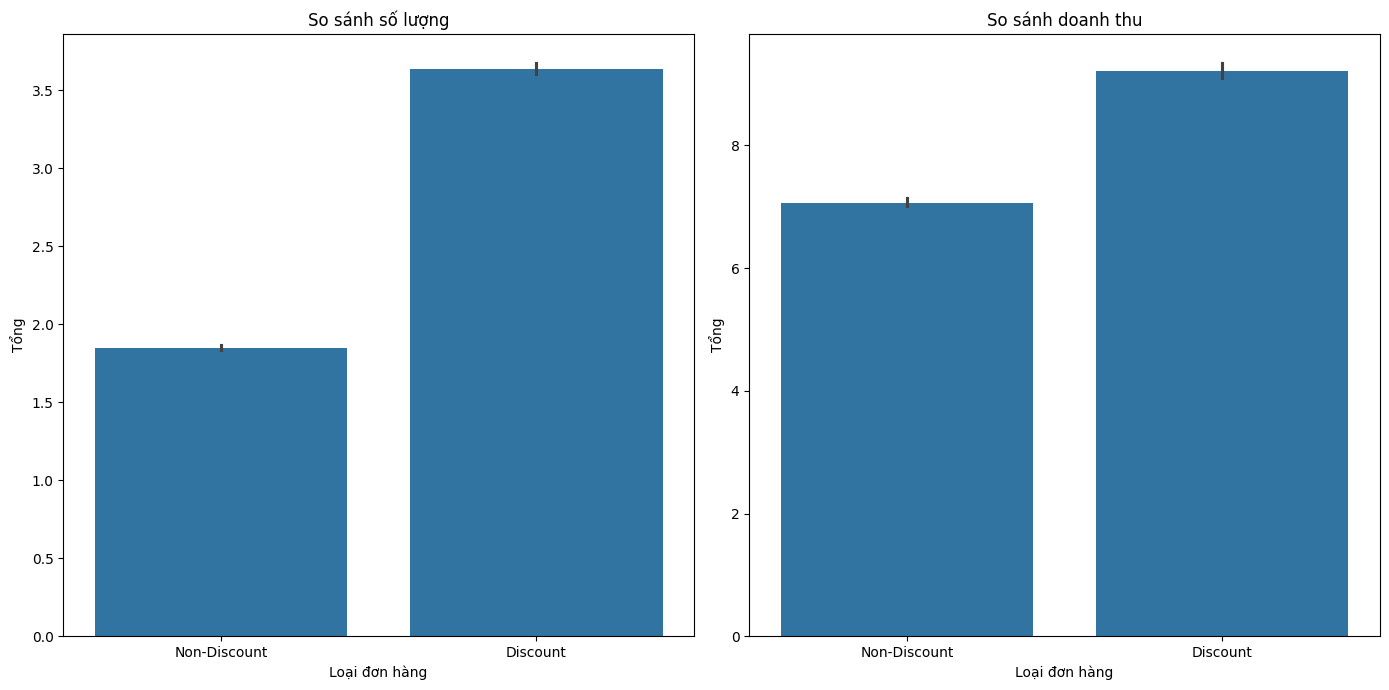

In [121]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.barplot(data=combined_df, x='order_type', y='Quantity')
plt.title('So sánh số lượng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

# Vẽ biểu đồ so sánh doanh thu
plt.subplot(1, 2, 2)
sns.barplot(data=combined_df, x='order_type', y='SalesAmount')
plt.title('So sánh doanh thu')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.tight_layout()
plt.show()

In [122]:
combined_df.groupby('order_type')['Quantity'].mean()

order_type
Discount       3.64
Non-Discount   1.85
Name: Quantity, dtype: float64

Nhận xét: Đơn hàng có giảm giá có số lượng trung bình món ăn và doanh thu cao hơn các đơn hàng không có giảm giá

##### 4.4.3 So sánh từng cửa hàng

###### 4.4.3.1 So sánh trung bình số lượng món và doanh thu của mỗi đơn hàng

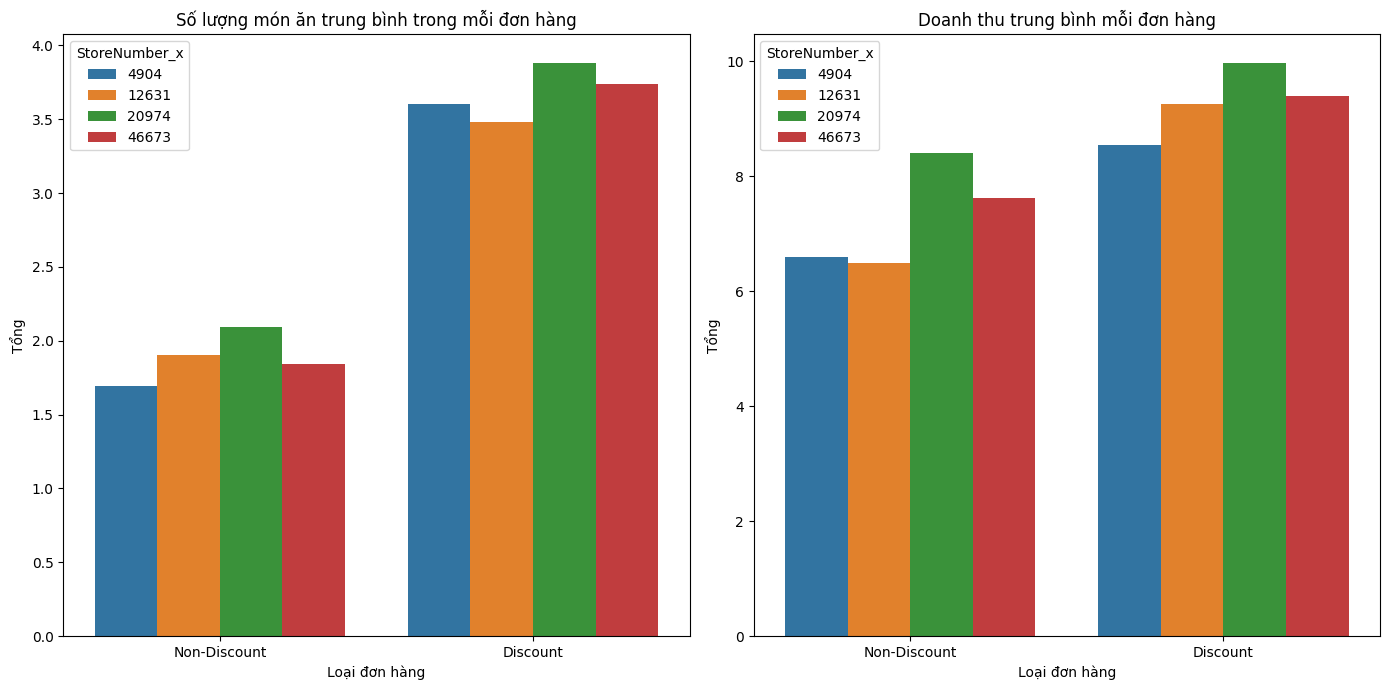

In [123]:
plt.figure(figsize=(14, 7))

# So sánh trung bình các chỉ số
plt.subplot(1, 2, 1)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(Quantity=('Quantity', 'mean')).reset_index(),
            x='order_type',
            y='Quantity',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('Số lượng món ăn trung bình trong mỗi đơn hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.subplot(1, 2, 2)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(SalesAmount=('SalesAmount', 'mean')).reset_index(),
            x='order_type',
            y='SalesAmount',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('Doanh thu trung bình mỗi đơn hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.tight_layout()
plt.show()

Nhận xét
- Chương trình giảm giá dường như có tác động tốt trong việc tăng số lượng món ăn ở của mỗi đơn hàng ở tất cả các cửa hàng, đặc biệt ở cửa hàng 4904.
- Chương trình giảm giá cũng giúp doanh thu mỗi đơn hàng tăng đặc biệt ở cửa hàng 4904

In [124]:
combined_df.pivot_table(
  index='order_type',
  columns='StoreNumber_x',
  values='Quantity',
  aggfunc='mean')

StoreNumber_x  4904   12631  20974  46673
order_type                               
Discount        3.60   3.48   3.88   3.74
Non-Discount    1.70   1.91   2.09   1.84

In [125]:
combined_df.pivot_table(
  index='order_type',
  columns='StoreNumber_x',
  values='SalesAmount',
  aggfunc='mean')

StoreNumber_x  4904   12631  20974  46673
order_type                               
Discount        8.55   9.26   9.97   9.40
Non-Discount    6.60   6.49   8.40   7.62

###### 4.4.3.2 So sánh tổng số lượng món, đơn hàng, và doanh thu

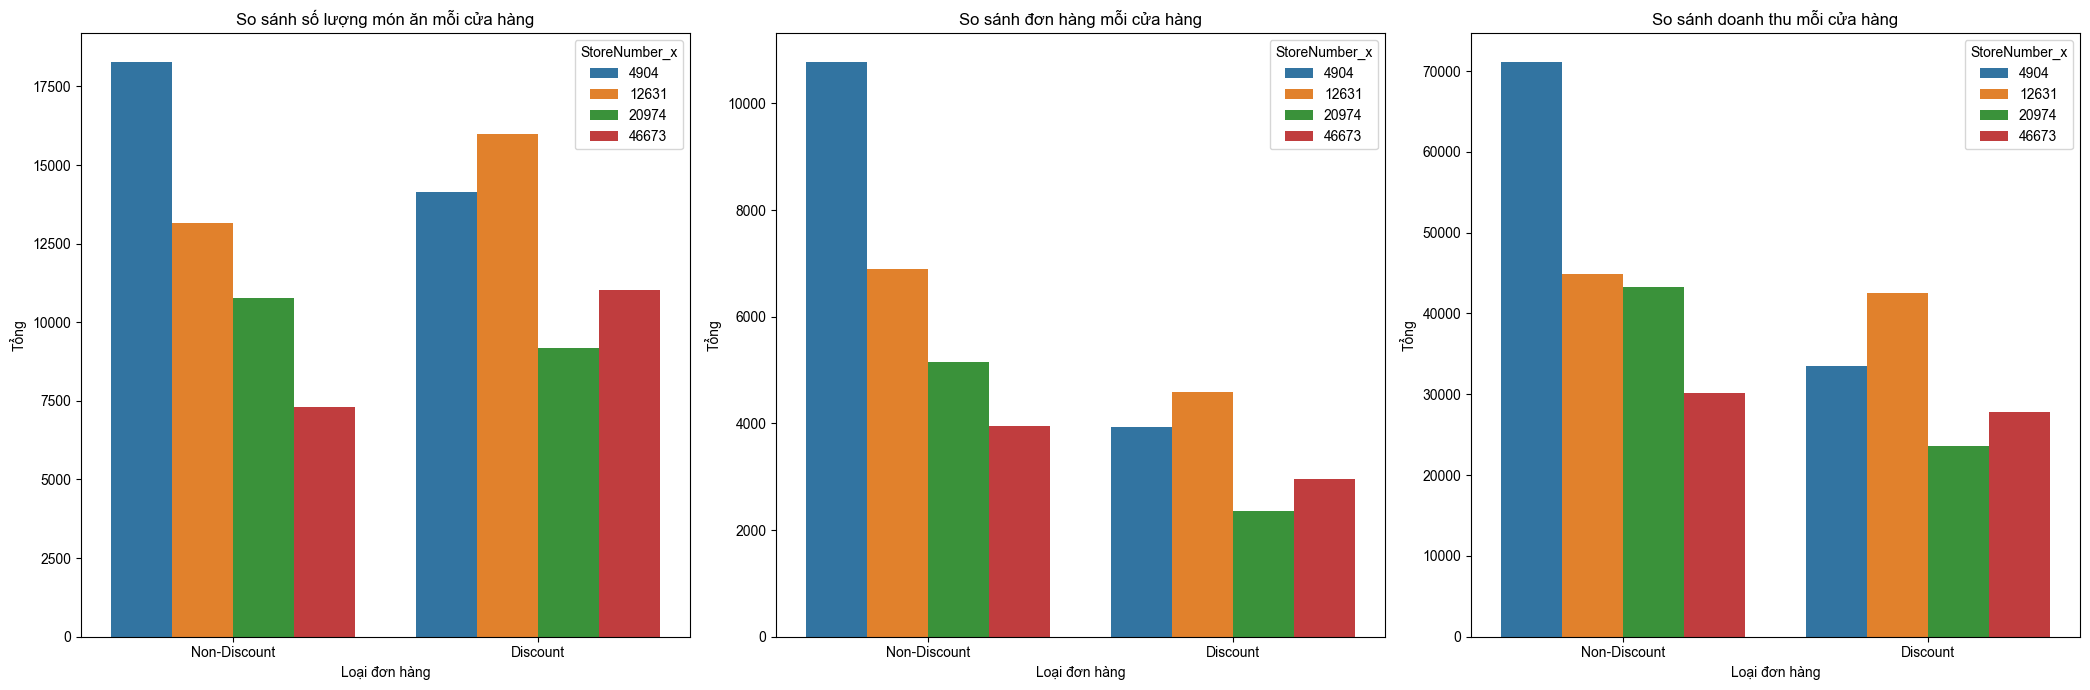

In [126]:
plt.figure(figsize=(21, 7))

# So sánh trung bình các chỉ số
plt.subplot(1, 3, 1)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(Quantity=('Quantity', 'sum')).reset_index(),
            x='order_type',
            y='Quantity',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('So sánh số lượng món ăn mỗi cửa hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.subplot(1, 3, 2)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(total_order=('MD5KEY_ORDERSALE', 'count')).reset_index(),
            x='order_type',
            y='total_order',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('So sánh đơn hàng mỗi cửa hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.subplot(1, 3, 3)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(SalesAmount=('SalesAmount', 'sum')).reset_index(),
            x='order_type',
            y='SalesAmount',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
sns.set_style("whitegrid")
plt.title('So sánh doanh thu mỗi cửa hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.tight_layout()
plt.show()

Nhận xét:

Số lượng món ăn
- Cửa hàng 4904 có tổng số lượng món ăn cao nhất trong các đơn hàng không giảm giá.
- Trong các đơn hàng giảm giá, cửa hàng 12631 có số lượng món ăn cao nhất, tiếp theo là cửa hàng 4904.

Số lượng đơn hàng
- Cửa hàng 4904 cũng dẫn đầu về số lượng đơn hàng không giảm giá.
- Cửa hàng 12631 có số lượng đơn hàng giảm giá cao nhất, tiếp theo là cửa hàng 4904

Doanh thu
- Cửa hàng 4904 có doanh thu cao nhất trong cả hai loại đơn hàng.
- Doanh thu từ các đơn hàng không giảm giá cao hơn so với doanh thu từ các đơn hàng giảm giá ở hầu hết các cửa hàng.

In [127]:
# Check dữ liệu trước và sau merge
print(df_menuitem['SalesAmount'].sum())
print(combined_df['SalesAmount'].sum())

316778.81
316778.81


In [128]:
print('Doanh thu đơn hàng không giảm giá:', combined_df[combined_df['order_type'] == 'Non-Discount']['SalesAmount'].sum())
print('Doanh thu đơn hàng có giảmm giá:', combined_df[combined_df['order_type'] == 'Discount']['SalesAmount'].sum())
print('Kiểm tra tổng:', combined_df[combined_df['order_type'] == 'Non-Discount']['SalesAmount'].sum() + combined_df[combined_df['order_type'] == 'Discount']['SalesAmount'].sum())

Doanh thu đơn hàng không giảm giá: 189332.31
Doanh thu đơn hàng có giảmm giá: 127446.5
Kiểm tra tổng: 316778.81


In [149]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [151]:
df_menuitem.groupby('StoreNumber')['DiscountPercentage'].mean()

StoreNumber
4904    5.50
12631   6.40
20974   3.97
46673   8.81
Name: DiscountPercentage, dtype: float64

In [155]:
df_store

STORE_ADDRESS1 DISTRIBUTION_REGION STORE_STATE STORE_CITY  STORE_ZIP  \
0    Ninth Street             Western  California   Berkeley      94710   
1     Shattuck Sq             Western  California   Berkeley      94704   
2   Myrtle Avenue           Northeast    New York  Ridgewood      11385   
3  Whitney Avenue           Northeast    New York   Elmhurst      11373   

    STORE_TYPE STORE_LOYALTY_FLAG  STORE_NUMBER  
0  Traditional                  N         46673  
1  Traditional                  Y          4904  
2  Traditional                  Y         12631  
3  Traditional                  Y         20974

# 5. Lưu file dùng cho tableau

## 5.1 Merger ordersale, menuitem, và store_restaurant

In [129]:
df_ordersale.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount',
       'MealLocation', 'TransactionId', 'StoreNumber', 'date'],
      dtype='object')

In [130]:
df_ordersale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43228 entries, 0 to 43227
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   MD5KEY_ORDERSALE  43228 non-null  object        
 1   ChangeReceived    43228 non-null  float64       
 2   OrderNumber       43228 non-null  int64         
 3   TaxAmount         43228 non-null  float64       
 4   MealLocation      43228 non-null  int64         
 5   TransactionId     43228 non-null  int64         
 6   StoreNumber       43228 non-null  int64         
 7   date              43228 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 2.6+ MB


In [131]:
# Lấy các cột cần thiết của bản ordersale
ordersale = df_ordersale[['MD5KEY_ORDERSALE', 'MealLocation']].copy()
ordersale.head()

MD5KEY_ORDERSALE  MealLocation
0  00BCB738A1F814DB960C25012E9913DF             0
1  03438C257BC2DD0037F35EC8BFC0C8E2             0
2  04AEF56CF3130AC1EFAD41C470F5245D             0
3  04BBFAD4E73C30EE2EC3B4E52509637C             0
4  061AE382DC127057E8ADBBF869CFB361             0

In [132]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage'],
      dtype='object')

In [133]:
menuitem = df_menuitem[['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'DiscountAmount', 'Price', 'Quantity', 'Id',
       'date', 'SalesAmount', 'day_of_week', 'DiscountPercentage']].copy()
menuitem.head()

MD5KEY_MENUITEM                  MD5KEY_ORDERSALE  \
0  001E0224E4EDA63D6FED96D59E0C1E76  072D3B76BE58E4553A373AF3206D2CA5   
1  003E4E20196B2F5BDD33CE06D2943EF4  14811D4F3458058007B0B6908C2DA393   
2  012A55E5551C95A559A7B074AE85117E  22FA6C39B7A15ABB6EB568E66A6B30E1   
3  01B07F1C6DC6945796571FC78735DA16  915B69612845BBD974C39AC105F5CA8C   
4  02DE19974DE5304BF243A1C2EC639495  CD6386C802450EDCF13A3D112D1F86EC   

  CategoryDescription  DepartmentDescription           Description  \
0            Footlong           Footlong Sub  Chickn Strips FtLong   
1            Fountain  Fountain Drink 21 oz.   21oz Fountain Drink   
2              6 Inch             6 Inch Sub         B.M.T. 6 inch   
3              6 Inch             6 Inch Sub  Veggie Delite 6 inch   
4              Add On     Add On 6in Portion        Avocado Add6in   

   StoreNumber  DiscountAmount  Price  Quantity   Id       date  SalesAmount  \
0        46673            0.00   7.75         1  326 2015-03-05         7.75   
1        46673            0.00   1.70         1  280 2015-03-05         1.70   
2        12631            0.61   4.25         1    8 2015-03-05         3.64   
3        12631            0.00   3.75         1   91 2015-03-05         3.75   
4        12631            0.00   0.50         1  564 2015-03-05         0.50   

  day_of_week  DiscountPercentage  
0    Thursday                0.00  
1    Thursday                0.00  
2    Thursday               14.35  
3    Thursday                0.00  
4    Thursday                0.00

In [134]:
df_store = pd.read_csv('../../../data/processed/20240722/3.store_restaurant_20240722.csv')

In [135]:
df_store.head()

STORE_ADDRESS1 DISTRIBUTION_REGION STORE_STATE STORE_CITY  STORE_ZIP  \
0    Ninth Street             Western  California   Berkeley      94710   
1     Shattuck Sq             Western  California   Berkeley      94704   
2   Myrtle Avenue           Northeast    New York  Ridgewood      11385   
3  Whitney Avenue           Northeast    New York   Elmhurst      11373   

    STORE_TYPE STORE_LOYALTY_FLAG  STORE_NUMBER  
0  Traditional                  N         46673  
1  Traditional                  Y          4904  
2  Traditional                  Y         12631  
3  Traditional                  Y         20974

In [136]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   STORE_ADDRESS1       4 non-null      object
 1   DISTRIBUTION_REGION  4 non-null      object
 2   STORE_STATE          4 non-null      object
 3   STORE_CITY           4 non-null      object
 4   STORE_ZIP            4 non-null      int64 
 5   STORE_TYPE           4 non-null      object
 6   STORE_LOYALTY_FLAG   4 non-null      object
 7   STORE_NUMBER         4 non-null      int64 
dtypes: int64(2), object(6)
memory usage: 384.0+ bytes


### Merge

In [137]:
merge_ordersale_menuitem = pd.merge(ordersale, menuitem, on='MD5KEY_ORDERSALE', how='left')

In [138]:
merge_ordersale_menuitem_store = pd.merge(merge_ordersale_menuitem, df_store, left_on='StoreNumber', right_on='STORE_NUMBER', how='left')

In [139]:
merge_ordersale_menuitem_store.columns

Index(['MD5KEY_ORDERSALE', 'MealLocation', 'MD5KEY_MENUITEM',
       'CategoryDescription', 'DepartmentDescription', 'Description',
       'StoreNumber', 'DiscountAmount', 'Price', 'Quantity', 'Id', 'date',
       'SalesAmount', 'day_of_week', 'DiscountPercentage', 'STORE_ADDRESS1',
       'DISTRIBUTION_REGION', 'STORE_STATE', 'STORE_CITY', 'STORE_ZIP',
       'STORE_TYPE', 'STORE_LOYALTY_FLAG', 'STORE_NUMBER'],
      dtype='object')

In [140]:
merge_ordersale_menuitem_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94027 entries, 0 to 94026
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   MD5KEY_ORDERSALE       94027 non-null  object        
 1   MealLocation           94027 non-null  int64         
 2   MD5KEY_MENUITEM        91420 non-null  object        
 3   CategoryDescription    91420 non-null  object        
 4   DepartmentDescription  91420 non-null  object        
 5   Description            91420 non-null  object        
 6   StoreNumber            91420 non-null  float64       
 7   DiscountAmount         91420 non-null  float64       
 8   Price                  91420 non-null  float64       
 9   Quantity               91420 non-null  float64       
 10  Id                     91420 non-null  float64       
 11  date                   91420 non-null  datetime64[ns]
 12  SalesAmount            91420 non-null  float64       
 13  d

In [141]:
# Check data 
print(merge_ordersale_menuitem_store['SalesAmount'].sum())
print(df_menuitem['SalesAmount'].sum())

316778.80999999994
316778.81


## 5.2 Tách outlier

In [142]:
# Tính Q1_merge_quantity (25th percentile) và Q3_merge_Quantity (75th percentile)
Q1_merge_quantity = merge_ordersale_menuitem_store['Quantity'].quantile(0.25)
Q3_merge_quantity = merge_ordersale_menuitem_store['Quantity'].quantile(0.75)

# Tính IQR_merge_quantity
IQR_merge_quantity = Q3_merge_quantity - Q1_merge_quantity

# Xác định giới hạn dưới và trên
lower_bound_merge_quantity = Q1_merge_quantity - 1.5 * IQR_merge_quantity
upper_bound_merge_quantity = Q3_merge_quantity + 1.5 * IQR_merge_quantity

# Xác định giá trị ngoại lai
outliers_merge_quantity = merge_ordersale_menuitem_store[(merge_ordersale_menuitem_store['Quantity'] < lower_bound_merge_quantity) | (merge_ordersale_menuitem_store['Quantity'] > upper_bound_merge_quantity)].copy()
non_outliers_merge_quantity = merge_ordersale_menuitem_store[~((merge_ordersale_menuitem_store['Quantity'] < lower_bound_merge_quantity) | (merge_ordersale_menuitem_store['Quantity'] > upper_bound_merge_quantity))].copy()

In [143]:
# Check data
print("Doanh thu outliers:", outliers_merge_quantity['SalesAmount'].sum())
print("Doanh thu non_outlier", non_outliers_merge_quantity['SalesAmount'].sum())
print("Tổng doanh thu outlier và non_outlier:", outliers_merge_quantity['SalesAmount'].sum() + non_outliers_merge_quantity['SalesAmount'].sum())
print('Tổng doanh thu file df_menuitem', df_menuitem['SalesAmount'].sum())

print("% doanh thu outlier:", outliers_merge_quantity['SalesAmount'].sum() / (outliers_merge_quantity['SalesAmount'].sum() + non_outliers_merge_quantity['SalesAmount'].sum()) * 100)

Doanh thu outliers: 30028.57
Doanh thu non_outlier 286750.24
Tổng doanh thu outlier và non_outlier: 316778.81
Tổng doanh thu file df_menuitem 316778.81
% doanh thu outlier: 9.479349328952907


## 5.3 Xuất file csv

In [144]:

# current_date = datetime.now().strftime("%Y%m%d")
# parent_dir = "../../../data/processed" 

# # Tạo đường dẫn đầy đủ cho thư mục mới
# new_folder_path = os.path.join(parent_dir, current_date)

# if not os.path.exists(new_folder_path):
#     os.makedirs(new_folder_path)
#     print(f"Thư mục '{new_folder_path}' đã được tạo thành công!")
# else:
#     print(f"Thư mục '{new_folder_path}' đã tồn tại.")

# # Xuất file tổng
# merge_ordersale_menuitem_store.to_csv(f'{new_folder_path}/1.merge_ordersale_menuitem_store_{current_date}.csv', index=False)

# # Xuất file outliers
# outliers_merge_quantity.to_csv(f'{new_folder_path}/2.outliers_merge_quantity_{current_date}.csv', index=False)

# # Xuất file non_outlier
# non_outliers_merge_quantity.to_csv(f'{new_folder_path}/3.non_outliers_merge_quantity_{current_date}.csv', index=False)


In [145]:
# Check dữ liệu
print(merge_ordersale_menuitem_store.shape)
print(merge_ordersale_menuitem_store['SalesAmount'].sum())
merge_ordersale_menuitem_store.isna().sum()

(94027, 23)
316778.80999999994


MD5KEY_ORDERSALE            0
MealLocation                0
MD5KEY_MENUITEM          2607
CategoryDescription      2607
DepartmentDescription    2607
Description              2607
StoreNumber              2607
DiscountAmount           2607
Price                    2607
Quantity                 2607
Id                       2607
date                     2607
SalesAmount              2607
day_of_week              2607
DiscountPercentage       2607
STORE_ADDRESS1           2607
DISTRIBUTION_REGION      2607
STORE_STATE              2607
STORE_CITY               2607
STORE_ZIP                2607
STORE_TYPE               2607
STORE_LOYALTY_FLAG       2607
STORE_NUMBER             2607
dtype: int64

In [146]:
merge_ordersale_menuitem_store_dropna = merge_ordersale_menuitem_store.dropna().copy()
print(merge_ordersale_menuitem_store_dropna.shape)
print(merge_ordersale_menuitem_store_dropna['SalesAmount'].sum())
merge_ordersale_menuitem_store_dropna.isna().sum()

(91420, 23)
316778.81


MD5KEY_ORDERSALE         0
MealLocation             0
MD5KEY_MENUITEM          0
CategoryDescription      0
DepartmentDescription    0
Description              0
StoreNumber              0
DiscountAmount           0
Price                    0
Quantity                 0
Id                       0
date                     0
SalesAmount              0
day_of_week              0
DiscountPercentage       0
STORE_ADDRESS1           0
DISTRIBUTION_REGION      0
STORE_STATE              0
STORE_CITY               0
STORE_ZIP                0
STORE_TYPE               0
STORE_LOYALTY_FLAG       0
STORE_NUMBER             0
dtype: int64

In [147]:
# Tính Q1_merge_quantity_dropna (25th percentile) và Q3_merge_Quantity_dropna (75th percentile)
Q1_merge_quantity_dropna = merge_ordersale_menuitem_store_dropna['Quantity'].quantile(0.25)
Q3_merge_quantity_dropna = merge_ordersale_menuitem_store_dropna['Quantity'].quantile(0.75)

# Tính IQR_merge_quantity_dropna
IQR_merge_quantity_dropna = Q3_merge_quantity_dropna - Q1_merge_quantity_dropna

# Xác định giới hạn dưới và trên
lower_bound_merge_quantity_dropna = Q1_merge_quantity_dropna - 1.5 * IQR_merge_quantity_dropna
upper_bound_merge_quantity_dropna = Q3_merge_quantity_dropna + 1.5 * IQR_merge_quantity_dropna

# Xác định giá trị ngoại lai
outliers_merge_quantity_dropna = merge_ordersale_menuitem_store_dropna[(merge_ordersale_menuitem_store_dropna['Quantity'] < lower_bound_merge_quantity_dropna) | (merge_ordersale_menuitem_store_dropna['Quantity'] > upper_bound_merge_quantity_dropna)].copy()
non_outliers_merge_quantity_dropna = merge_ordersale_menuitem_store_dropna[~((merge_ordersale_menuitem_store_dropna['Quantity'] < lower_bound_merge_quantity_dropna) | (merge_ordersale_menuitem_store_dropna['Quantity'] > upper_bound_merge_quantity_dropna))].copy()

In [148]:

# current_date = datetime.now().strftime("%Y%m%d")
# parent_dir = "../../../data/processed" 

# # Tạo đường dẫn đầy đủ cho thư mục mới
# new_folder_path = os.path.join(parent_dir, current_date)

# if not os.path.exists(new_folder_path):
#     os.makedirs(new_folder_path)
#     print(f"Thư mục '{new_folder_path}' đã được tạo thành công!")
# else:
#     print(f"Thư mục '{new_folder_path}' đã tồn tại.")

# # Xuất file tổng
# merge_ordersale_menuitem_store_dropna.to_csv(f'{new_folder_path}/1.merge_ordersale_menuitem_store_{current_date}.csv', index=False)

# # Xuất file outliers
# outliers_merge_quantity_dropna.to_csv(f'{new_folder_path}/2.outliers_merge_quantity_{current_date}.csv', index=False)

# # Xuất file non_outlier
# non_outliers_merge_quantity_dropna.to_csv(f'{new_folder_path}/3.non_outliers_merge_quantity_{current_date}.csv', index=False)


In [156]:
merge_ordersale_menuitem_store_dropna.columns

Index(['MD5KEY_ORDERSALE', 'MealLocation', 'MD5KEY_MENUITEM',
       'CategoryDescription', 'DepartmentDescription', 'Description',
       'StoreNumber', 'DiscountAmount', 'Price', 'Quantity', 'Id', 'date',
       'SalesAmount', 'day_of_week', 'DiscountPercentage', 'STORE_ADDRESS1',
       'DISTRIBUTION_REGION', 'STORE_STATE', 'STORE_CITY', 'STORE_ZIP',
       'STORE_TYPE', 'STORE_LOYALTY_FLAG', 'STORE_NUMBER'],
      dtype='object')

In [168]:
merge_ordersale_menuitem_store_dropna_groupby = merge_ordersale_menuitem_store_dropna.groupby(['date', 'day_of_week', 'StoreNumber', 'STORE_STATE', 'STORE_CITY', 'STORE_ADDRESS1', 'MD5KEY_ORDERSALE']).agg(
  revenue=('SalesAmount', 'sum'),
  order=('MD5KEY_ORDERSALE', 'count'),
  DiscountPercentage=('DiscountPercentage', 'mean')
).reset_index()

merge_ordersale_menuitem_store_dropna_groupby

date day_of_week  StoreNumber STORE_STATE STORE_CITY  \
0     2015-03-05    Thursday     12631.00    New York  Ridgewood   
1     2015-03-05    Thursday     12631.00    New York  Ridgewood   
2     2015-03-05    Thursday     12631.00    New York  Ridgewood   
3     2015-03-05    Thursday     12631.00    New York  Ridgewood   
4     2015-03-05    Thursday     12631.00    New York  Ridgewood   
...          ...         ...          ...         ...        ...   
40616 2015-06-15      Monday     46673.00  California   Berkeley   
40617 2015-06-15      Monday     46673.00  California   Berkeley   
40618 2015-06-15      Monday     46673.00  California   Berkeley   
40619 2015-06-15      Monday     46673.00  California   Berkeley   
40620 2015-06-15      Monday     46673.00  California   Berkeley   

      STORE_ADDRESS1                  MD5KEY_ORDERSALE  revenue  order  \
0      Myrtle Avenue  03438C257BC2DD0037F35EC8BFC0C8E2     6.00      2   
1      Myrtle Avenue  04BBFAD4E73C30EE2EC3B4E52509637C    13.05      5   
2      Myrtle Avenue  0653EFBC62931D45E96BFB82040123EA     5.50      1   
3      Myrtle Avenue  09F16AC6C629944163B1E60A4CF104F0    13.00      1   
4      Myrtle Avenue  09F6BBFD8EE4B35CF5F2F9F0147A423D     3.75      1   
...              ...                               ...      ...    ...   
40616   Ninth Street  F738D3985286CCB0C086E7DCD1BBB2E7     1.80      1   
40617   Ninth Street  F76EC107396D301F023CE2BBA36DBEF7     9.00      1   
40618   Ninth Street  F85650D5293A041897DA3C3FBC8B2B7C     8.25      3   
40619   Ninth Street  FA5813D76F93E1D5D2BB1E6AD4A0B80A     6.20      2   
40620   Ninth Street  FD570797AC0A9AFC3953A30EC5355829     1.90      1   

       DiscountPercentage  
0                    0.00  
1                    4.37  
2                    0.00  
3                    0.00  
4                    0.00  
...                   ...  
40616                0.00  
40617                0.00  
40618                3.55  
40619                0.00  
40620                0.00  

[40621 rows x 10 columns]

In [169]:
merge_ordersale_menuitem_store_dropna_groupby_store = merge_ordersale_menuitem_store_dropna.groupby(['StoreNumber', 'STORE_STATE', 'STORE_CITY', 'STORE_ADDRESS1']).agg(
  revenue=('SalesAmount', 'sum'),
  order=('MD5KEY_ORDERSALE', 'count'),
  DiscountPercentage=('DiscountPercentage', 'mean')
).reset_index().sort_values('revenue', ascending=False)

merge_ordersale_menuitem_store_dropna_groupby_store

StoreNumber STORE_STATE STORE_CITY  STORE_ADDRESS1   revenue  order  \
0      4904.00  California   Berkeley     Shattuck Sq 104642.35  29761   
1     12631.00    New York  Ridgewood   Myrtle Avenue  87380.05  26287   
2     20974.00    New York   Elmhurst  Whitney Avenue  66829.26  18261   
3     46673.00  California   Berkeley    Ninth Street  57927.15  17111   

   DiscountPercentage  
0                5.50  
1                6.40  
2                3.97  
3                8.81

In [172]:
merge_ordersale_menuitem_store_dropna_groupby_store['StoreName'] = merge_ordersale_menuitem_store_dropna_groupby_store['STORE_STATE'] + "-" + merge_ordersale_menuitem_store_dropna_groupby_store['STORE_CITY']+ "-" + merge_ordersale_menuitem_store_dropna_groupby_store['STORE_ADDRESS1']
merge_ordersale_menuitem_store_dropna_groupby_store

StoreNumber STORE_STATE STORE_CITY  STORE_ADDRESS1   revenue  order  \
0      4904.00  California   Berkeley     Shattuck Sq 104642.35  29761   
1     12631.00    New York  Ridgewood   Myrtle Avenue  87380.05  26287   
2     20974.00    New York   Elmhurst  Whitney Avenue  66829.26  18261   
3     46673.00  California   Berkeley    Ninth Street  57927.15  17111   

   DiscountPercentage                         StoreName  
0                5.50   California-Berkeley-Shattuck Sq  
1                6.40  New York-Ridgewood-Myrtle Avenue  
2                3.97  New York-Elmhurst-Whitney Avenue  
3                8.81  California-Berkeley-Ninth Street

In [173]:
merge_ordersale_menuitem_store_dropna_groupby_store[['StoreName', 'revenue', 'order', 'DiscountPercentage']]

StoreName   revenue  order  DiscountPercentage
0   California-Berkeley-Shattuck Sq 104642.35  29761                5.50
1  New York-Ridgewood-Myrtle Avenue  87380.05  26287                6.40
2  New York-Elmhurst-Whitney Avenue  66829.26  18261                3.97
3  California-Berkeley-Ninth Street  57927.15  17111                8.81